In [116]:
from IPython.display import HTML
HTML('<style>div.text_cell_render{font-size:130%;}</style>')

In [117]:
%load_ext version_information
%version_information pandas

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.7.1 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.2.0
OS Darwin 18.2.0 x86_64 i386 64bit
pandas 0.23.4
Mon Apr 29 13:34:54 2019 PDT

# Goalie Pull Bayes Optimize

 - Exploratory analysis

## Explore Parsed Goalie Pull Data

In [118]:
import pandas as pd
import numpy as np
import os
import re
import datetime
import time
import glob
from tqdm import tqdm_notebook
from colorama import Fore, Style

In [191]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelpad'] = 10
plt.style.use('ggplot')

def savefig(name):
    plt.savefig(f'../../figures/{name}.png', bbox_inches='tight', dpi=300)

In [224]:
ls ../../data/processed/

csv/ pkl/


In [225]:
ls ../../data/processed/pkl

20032004_goalie_pulls_2019-03-01.pkl  20122013_goalie_pulls_2019-04-25.pkl
20052006_goalie_pulls_2019-03-01.pkl  20132014_goalie_pulls_2019-04-25.pkl
20062007_goalie_pulls_2019-03-01.pkl  20142015_goalie_pulls_2019-04-25.pkl
20072008_goalie_pulls_2019-04-25.pkl  20152016_goalie_pulls_2019-04-25.pkl
20082009_goalie_pulls_2019-04-25.pkl  20162017_goalie_pulls_2019-04-25.pkl
20092010_goalie_pulls_2019-04-25.pkl  20172018_goalie_pulls_2019-04-25.pkl
20102011_goalie_pulls_2019-04-25.pkl  20182019_goalie_pulls_2019-04-25.pkl
20112012_goalie_pulls_2019-04-25.pkl  tmp/


In [226]:
files = sorted(glob.glob('../../data/processed/pkl/*'))
files

['../../data/processed/pkl/20032004_goalie_pulls_2019-03-01.pkl',
 '../../data/processed/pkl/20052006_goalie_pulls_2019-03-01.pkl',
 '../../data/processed/pkl/20062007_goalie_pulls_2019-03-01.pkl',
 '../../data/processed/pkl/20072008_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20082009_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20092010_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20102011_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20112012_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20122013_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20132014_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20142015_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20152016_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20162017_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20172018_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20182019_goalie_pulls_2019-04-25.pkl',
 '../../da

In [227]:
def load_data():
    files = [
        '../../data/processed/pkl/20032004_goalie_pulls_2019-03-01.pkl',
 '../../data/processed/pkl/20052006_goalie_pulls_2019-03-01.pkl',
 '../../data/processed/pkl/20062007_goalie_pulls_2019-03-01.pkl',
 '../../data/processed/pkl/20072008_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20082009_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20092010_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20102011_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20112012_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20122013_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20132014_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20142015_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20152016_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20162017_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20172018_goalie_pulls_2019-04-25.pkl',
 '../../data/processed/pkl/20182019_goalie_pulls_2019-04-25.pkl',
            ]
    return pd.concat((pd.read_pickle(f) for f in files), sort=False)

def clean_df(df):
    _df = df.copy()
    
    len_0 = _df.shape[0]
    print('Removing goal_for_time < 15 mins')
    _df = _df[~(_df.goal_for_time < datetime.timedelta(seconds=15*60))]
    print(f'Removed {len_0 - _df.shape[0]} total rows')
    
    if 'game_end_time' in df.columns:
        len_0 = _df.shape[0]
        print('Removing game_end_time < 15 mins')
        _df = _df[~(_df.game_end_time < datetime.timedelta(seconds=60*15))]
        print(f'Removed {len_0 - _df.shape[0]} total rows')
    
    return _df

In [228]:
df = load_data()
df = clean_df(df)

Removing goal_for_time < 15 mins
Removed 115 total rows
Removing game_end_time < 15 mins
Removed 0 total rows


In [229]:
# Label the outcomes
df['label'] = ''
label_masks = {
    'goal_for': ~(df.goal_for_time.isnull()),
    'goal_against': ~(df.goal_against_time.isnull()),
    'no_goals': ~(df.game_end_timedelta.isnull()),   
}
for label, mask in label_masks.items():
    df.loc[mask, 'label'] = label
df.loc[df.label == '', 'label'] = float('nan')
df.label.isnull().sum()

0

In [230]:
df.head()

,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta,game_end_time,label
0,20032004,710,CHI,2004-01-21,3,00:19:44,NaT,00:19:47,NaT,00:00:03,NaT,NaT,goal_against
1,20032004,205,MIN,2003-11-08,3,00:19:58,NaT,NaT,NaT,NaT,00:00:02,NaT,no_goals
2,20032004,1230,S.J,2004-04-04,3,00:18:39,00:19:40,NaT,00:01:01,NaT,NaT,NaT,goal_for
3,20032004,655,PHX,2004-01-13,3,00:19:03,NaT,00:19:25,NaT,00:00:22,NaT,NaT,goal_against
4,20032004,985,PHX,2004-03-02,3,00:18:34,00:18:44,NaT,00:00:10,NaT,NaT,NaT,goal_for


In [231]:
df.tail()

,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta,game_end_time,label
901,20182019,1265,WSH,2019-04-06,3,00:16:40,NaT,00:17:27,NaT,00:00:47,NaT,NaT,goal_against
902,20182019,1266,CHI,2019-04-06,3,00:17:39,NaT,00:17:51,NaT,00:00:12,NaT,NaT,goal_against
903,20182019,1268,CGY,2019-04-06,3,00:19:34,NaT,NaT,NaT,NaT,00:00:26,00:20:00,no_goals
904,20182019,1270,VGK,2019-04-06,3,00:18:37.500000,NaT,00:19:05,NaT,00:00:27.500000,NaT,NaT,goal_against
905,20182019,1271,COL,2019-04-06,3,00:17:07,NaT,00:19:15,NaT,00:02:08,NaT,NaT,goal_against


In [232]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pull_period,11168,3,0,3,3,3,3,3
pull_time,11168,0 days 00:18:32.484195,0 days 00:00:52.298570,0 days 00:07:13,0 days 00:18:10,0 days 00:18:40,0 days 00:19:05.500000,0 days 00:19:59.500000
goal_for_time,1496,0 days 00:18:58.131684,0 days 00:00:50.558413,0 days 00:15:10,0 days 00:18:35,0 days 00:19:07.500000,0 days 00:19:35,0 days 00:19:59
goal_against_time,3736,0 days 00:19:02.648019,0 days 00:00:54.536523,0 days 00:08:14,0 days 00:18:43.750000,0 days 00:19:15,0 days 00:19:38,0 days 00:19:59
goal_for_timedelta,1496,0 days 00:00:45.730614,0 days 00:00:34.889763,0 days 00:00:00,0 days 00:00:19.500000,0 days 00:00:39,0 days 00:01:03,0 days 00:04:06
goal_against_timedelta,3736,0 days 00:00:48.343549,0 days 00:00:35.784661,0 days 00:00:00,0 days 00:00:21.500000,0 days 00:00:40,0 days 00:01:06.500000,0 days 00:04:51
game_end_timedelta,5937,0 days 00:01:11.010948,0 days 00:00:41.067886,0 days 00:00:00.500000,0 days 00:00:42.500000,0 days 00:01:07,0 days 00:01:32,0 days 00:05:22.500000
game_end_time,4632,0 days 00:20:00,0 days 00:00:00,0 days 00:20:00,0 days 00:20:00,0 days 00:20:00,0 days 00:20:00,0 days 00:20:00


In [233]:
df.dtypes

season                             object
game_number                        object
team_name                          object
date                       datetime64[ns]
pull_period                         int64
pull_time                 timedelta64[ns]
goal_for_time             timedelta64[ns]
goal_against_time         timedelta64[ns]
goal_for_timedelta        timedelta64[ns]
goal_against_timedelta    timedelta64[ns]
game_end_timedelta        timedelta64[ns]
game_end_time             timedelta64[ns]
label                              object
dtype: object

In [234]:
df.isnull().sum() / df.shape[0]

season                    0.000000
game_number               0.000000
team_name                 0.000000
date                      0.000090
pull_period               0.000000
pull_time                 0.000000
goal_for_time             0.866046
goal_against_time         0.665473
goal_for_timedelta        0.866046
goal_against_timedelta    0.665473
game_end_timedelta        0.468392
game_end_time             0.585244
label                     0.000000
dtype: float64

In [235]:
df.columns

Index(['season', 'game_number', 'team_name', 'date', 'pull_period',
       'pull_time', 'goal_for_time', 'goal_against_time', 'goal_for_timedelta',
       'goal_against_timedelta', 'game_end_timedelta', 'game_end_time',
       'label'],
      dtype='object')

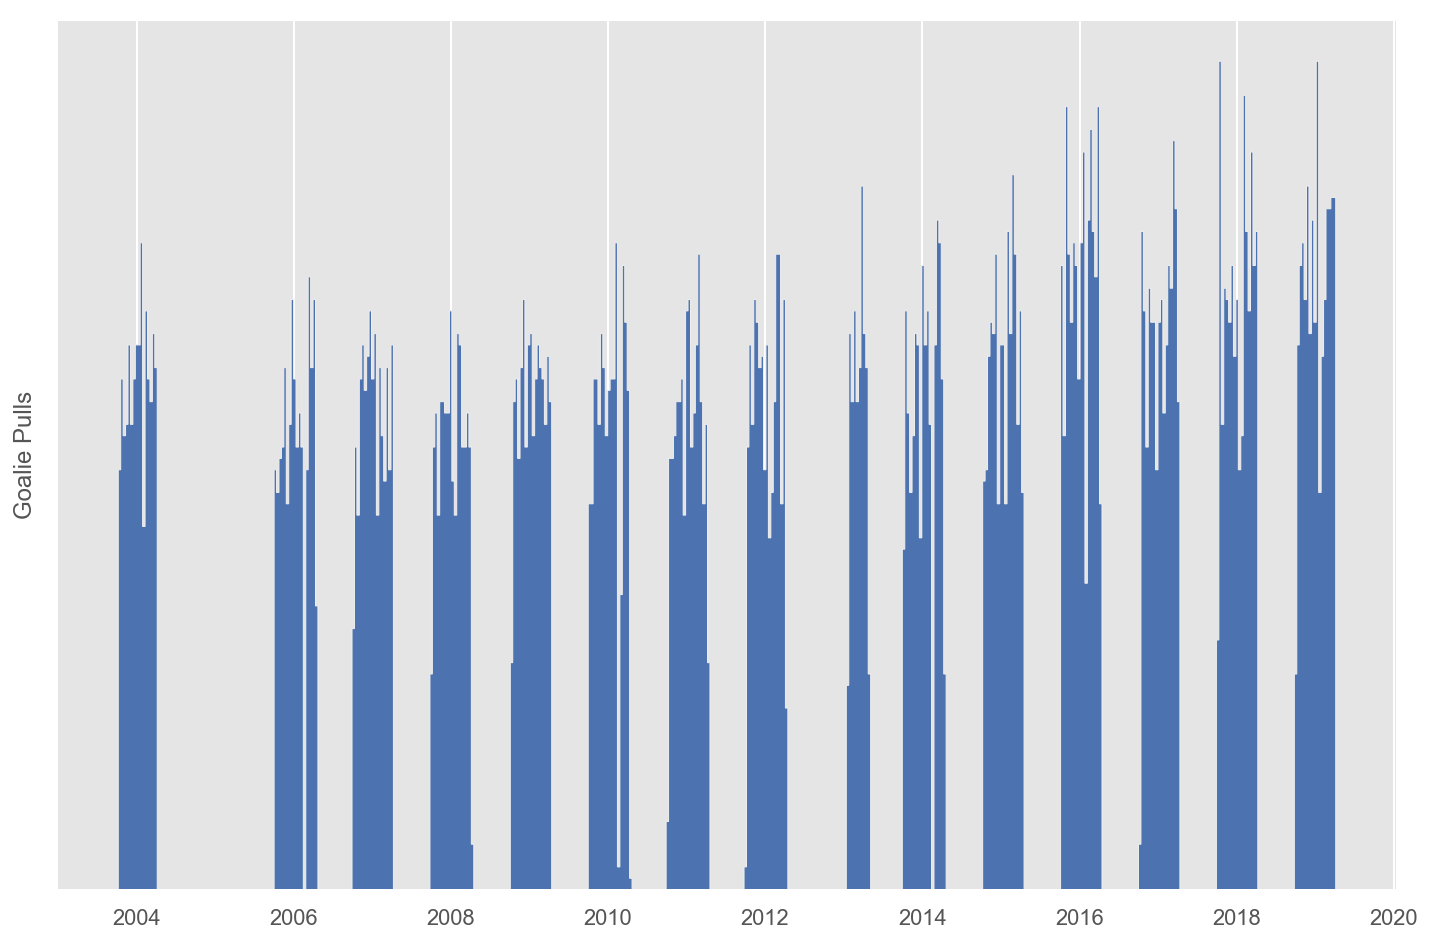

In [236]:
plt.ylabel('Goalie Pulls')
plt.yticks([])
df.date.hist(
    color='b',
    bins=500,
    histtype='stepfilled')
savefig('goalie_pulls_2003-2019')

In [237]:
df.groupby('season').size().sort_index(ascending=True).rename('counts').reset_index()

,season,counts
0,20032004,716
1,20052006,702
2,20062007,710
3,20072008,683
4,20082009,735
5,20092010,703
6,20102011,712
7,20112012,733
8,20122013,426
9,20132014,749


In [238]:
import inspect
print(inspect.getsource(savefig))

def savefig(name):
    plt.savefig(f'../../figures/{name}.png', bbox_inches='tight', dpi=300)



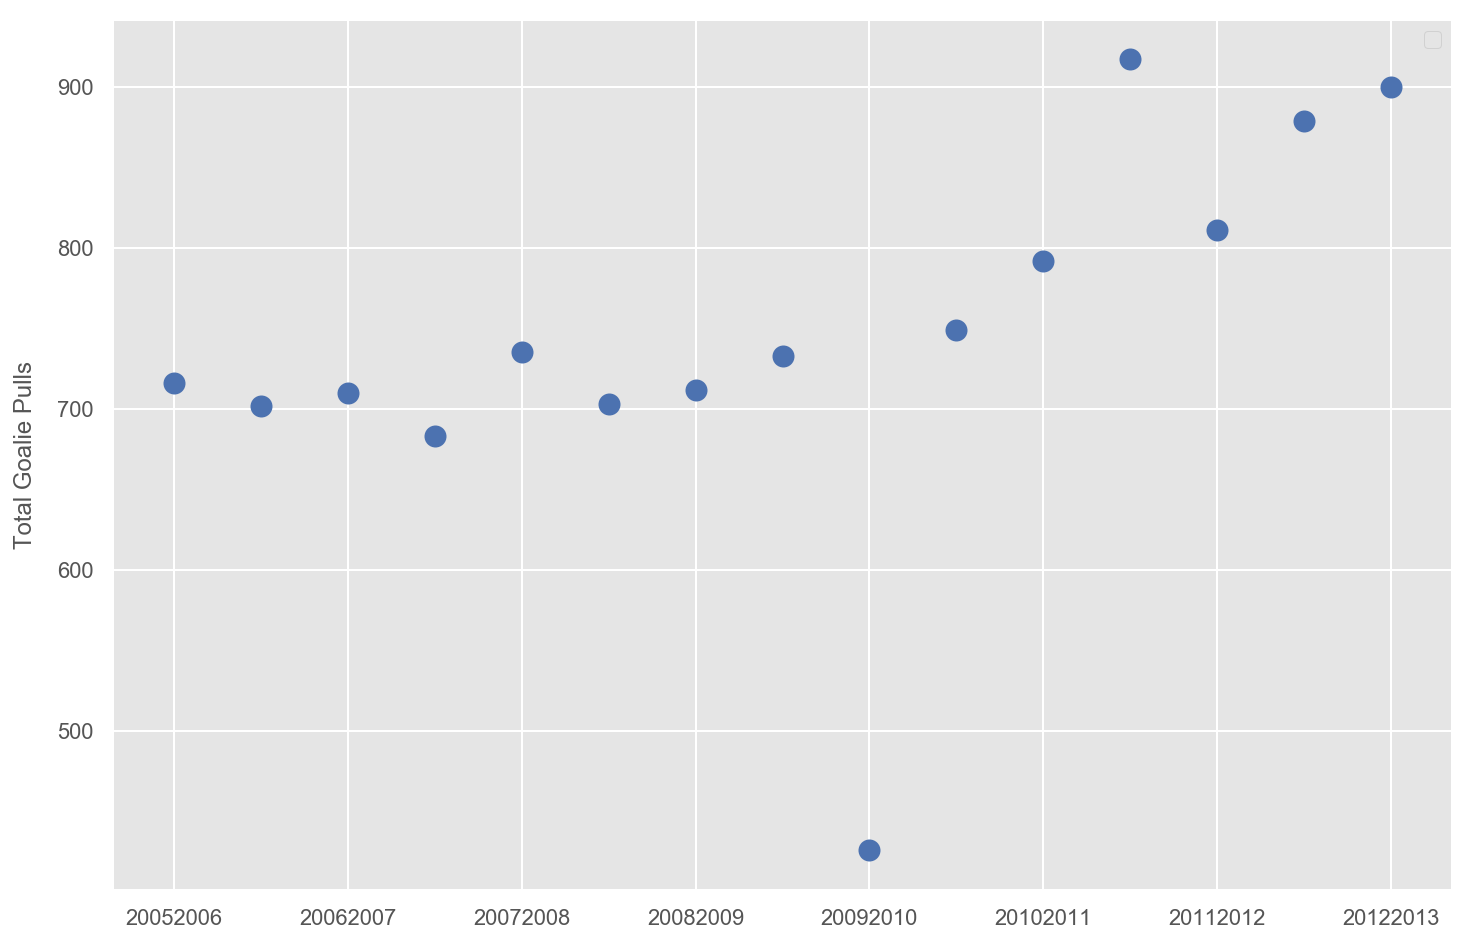

In [240]:
fig, ax = plt.subplots()
s = df.groupby('season').size().sort_index(ascending=True).rename('counts').reset_index()
ax = s.plot(marker='o', lw=0, ax=ax, color='b', ms=10)
ax.set_xticklabels(s.season.tolist());
# ax.set_ylim(600, 1100)
plt.legend([])
plt.ylabel('Total Goalie Pulls')
savefig('goalie_pulls_by_season')

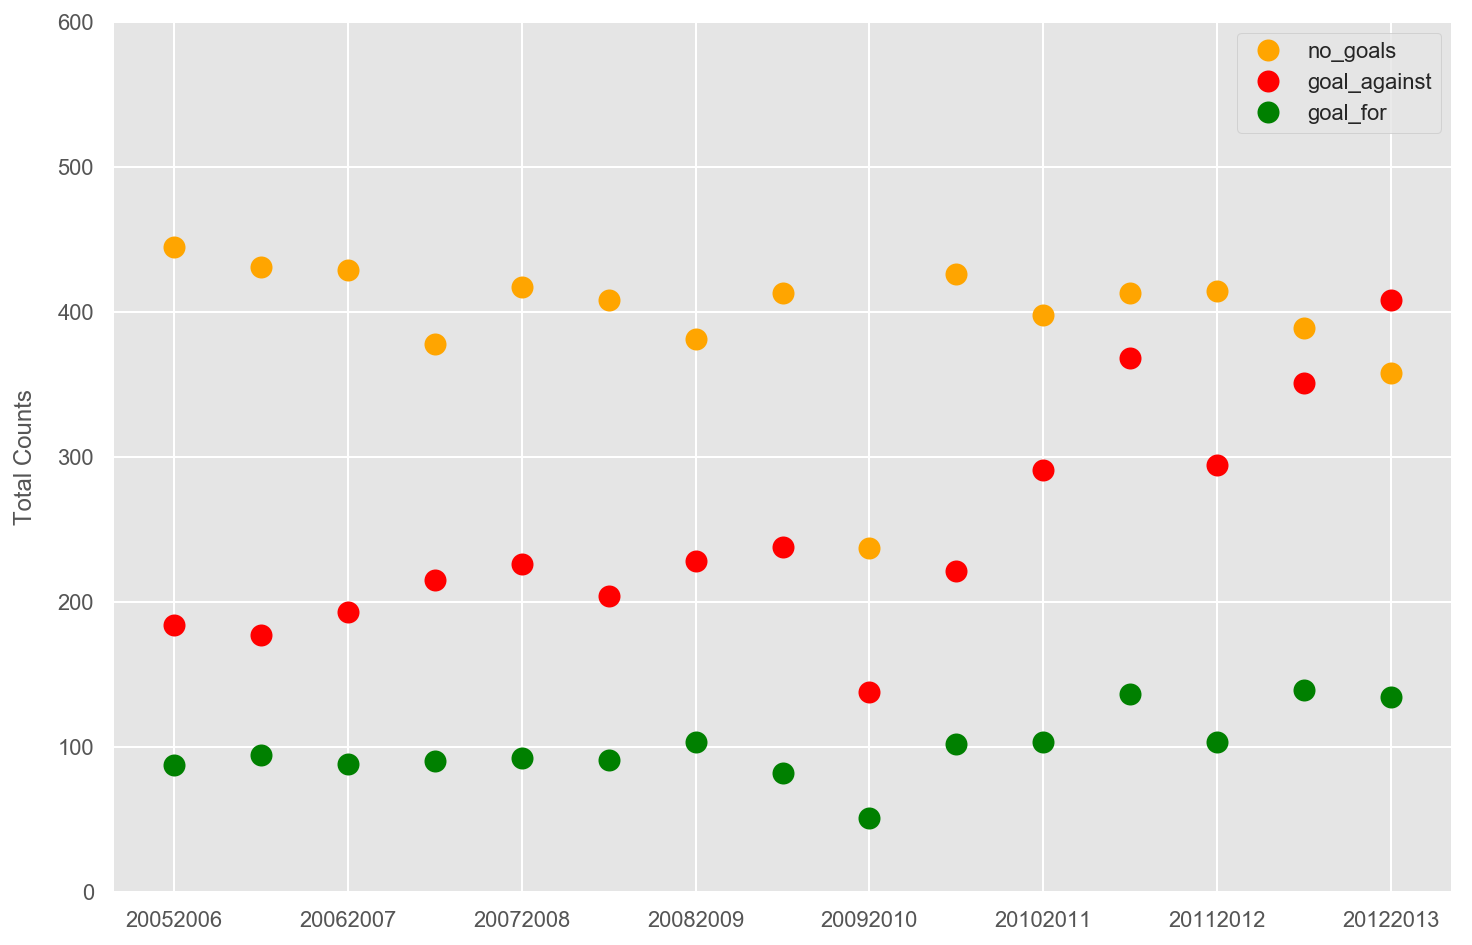

In [219]:
fig, ax = plt.subplots()
iterables = zip(['orange', 'red', 'green'],
                ['no_goals', 'goal_against', 'goal_for'])

axes = []
for c, label in iterables:
    m = df.label==label
    s = df[m].groupby('season').size().sort_index(ascending=True).rename(label).reset_index()
    axes.append(s.plot(marker='o', lw=0, ax=ax, ms=10, color=c, label=label))
    plt.legend()

ax.set_xticklabels(s.season.tolist());
ax.set_ylim(0, 600)
plt.ylabel('Total Counts')
savefig('goalie_pull_outcomes_by_season')

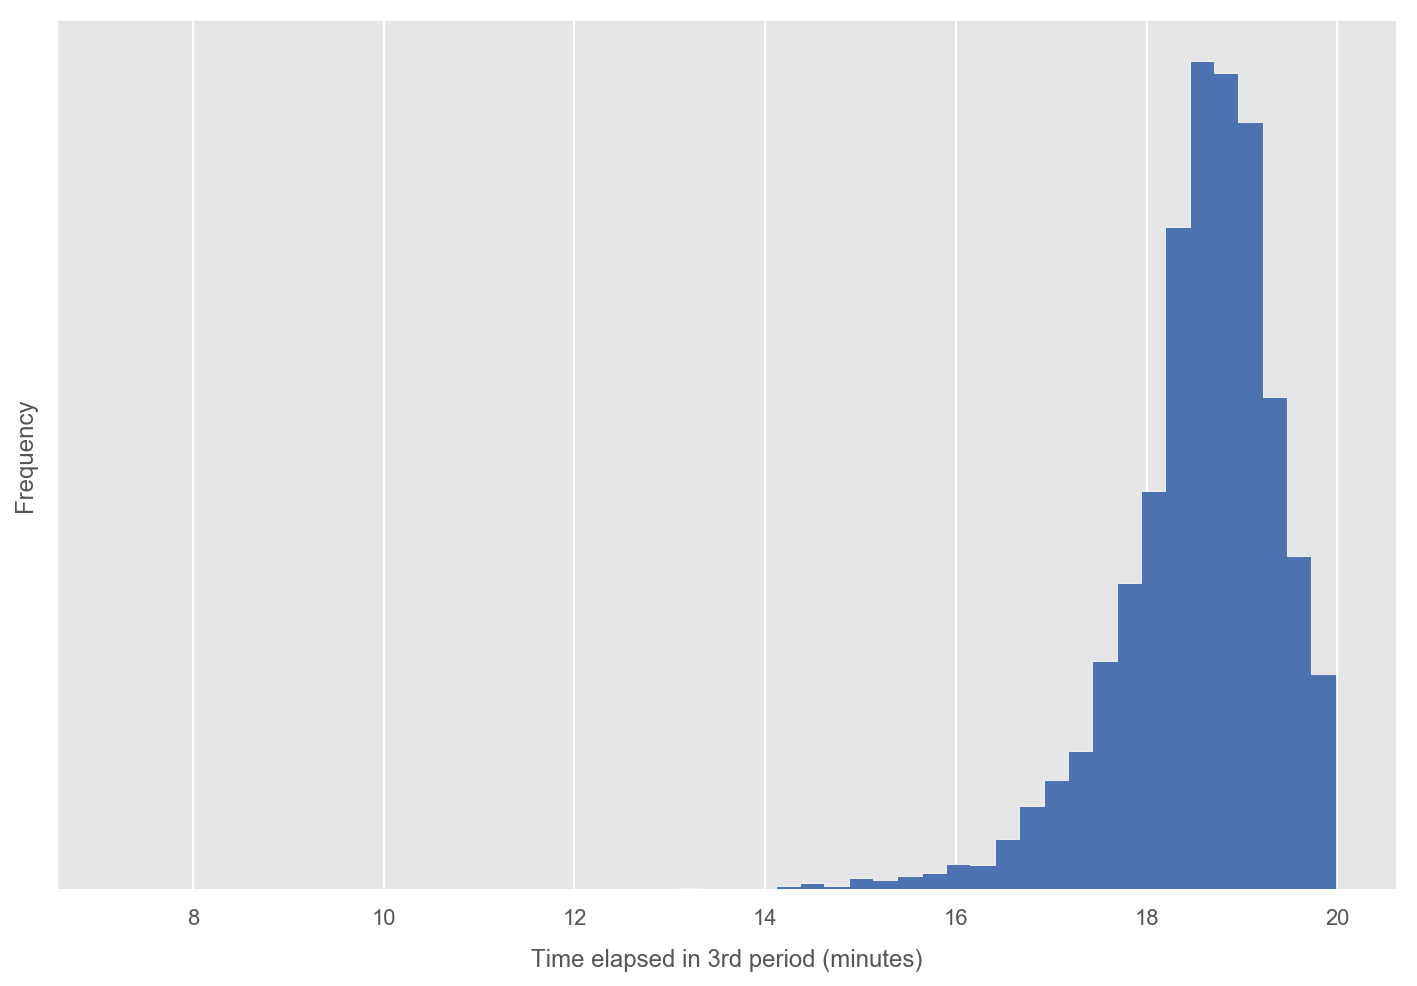

In [132]:
col = 'pull_time'
(df[col].astype('timedelta64[s]') / 60)\
    .plot.hist(bins=50,
               color='b',
               histtype='stepfilled')
plt.xlabel('Time elapsed in 3rd period (minutes)')
plt.yticks([])
savefig(plt, 'goalie_pull_game_times_hist')

We're interested in knowing about the outcome, given the pull time. This way we can look at the odds of scoring as a function of game time elapsed.

In [133]:
df.head()

,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta,game_end_time,label
0,20032004,710,CHI,2004-01-21,3,00:19:44,NaT,00:19:47,NaT,00:00:03,NaT,NaT,goal_against
1,20032004,205,MIN,2003-11-08,3,00:19:58,NaT,NaT,NaT,NaT,00:00:02,NaT,no_goals
2,20032004,1230,S.J,2004-04-04,3,00:18:39,00:19:40,NaT,00:01:01,NaT,NaT,NaT,goal_for
3,20032004,655,PHX,2004-01-13,3,00:19:03,NaT,00:19:25,NaT,00:00:22,NaT,NaT,goal_against
4,20032004,985,PHX,2004-03-02,3,00:18:34,00:18:44,NaT,00:00:10,NaT,NaT,NaT,goal_for


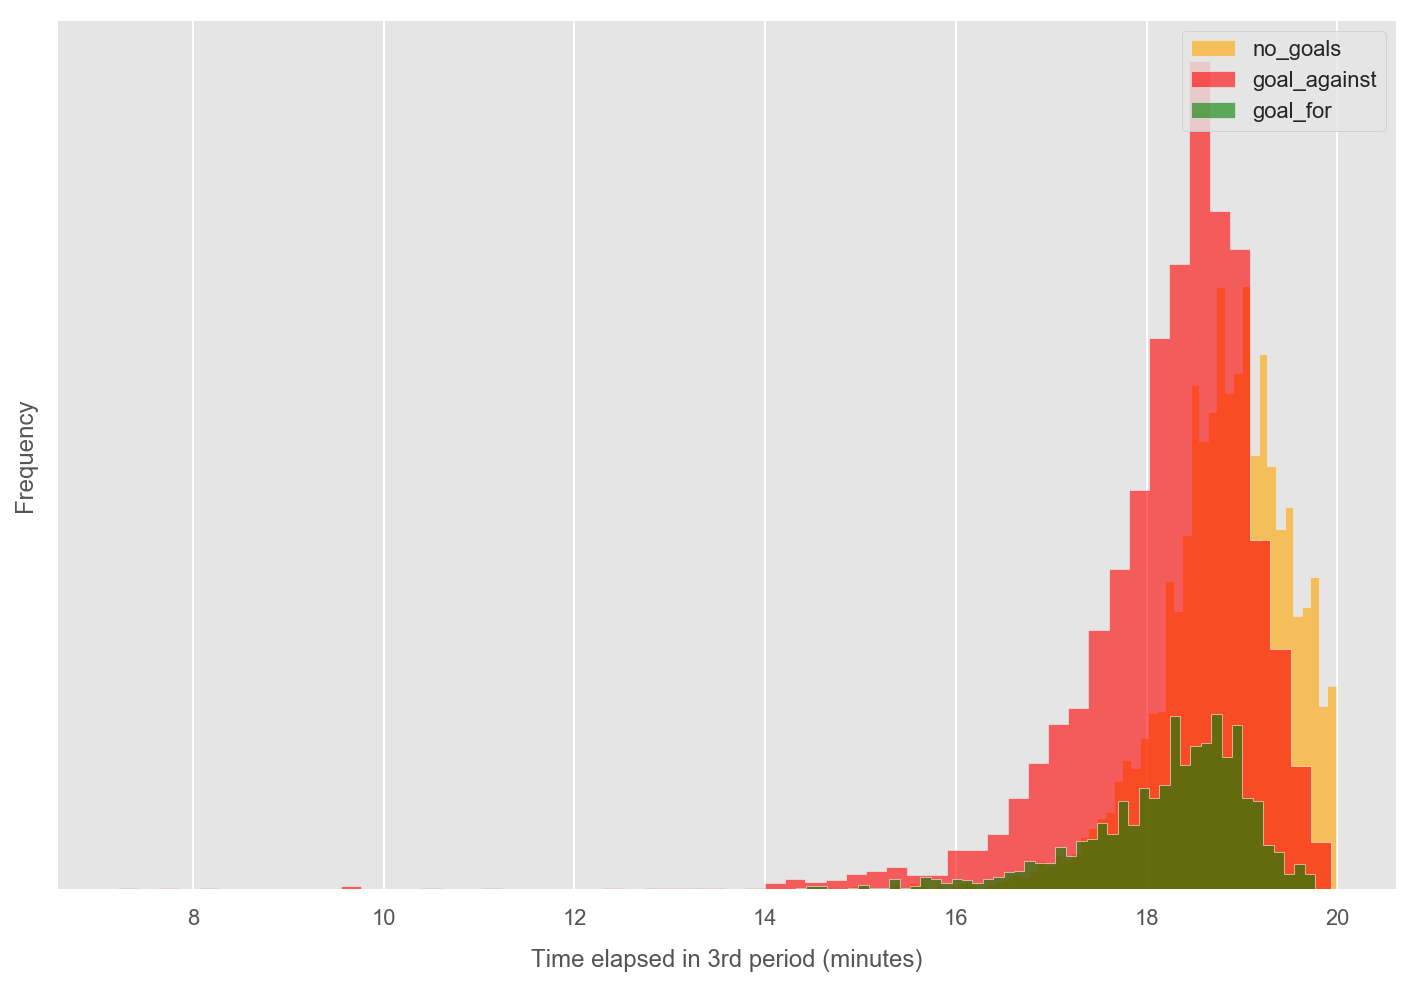

In [134]:
# ax = plt.subplot(111)
# ax.set_prop_cycle(color=['red', 'green', 'orange'])

df['pull_time_seconds'] = df['pull_time'].astype('timedelta64[s]') / 60

iterables = zip(['orange', 'red', 'green'],
                ['no_goals', 'goal_against', 'goal_for'])

for c, label in iterables:
    (df[df.label==label]['pull_time_seconds']
         .plot.hist(bins=60,
                    alpha=0.6,
                    color=c,
                    histtype='stepfilled',
                    label=label))

plt.xlabel('Time elapsed in 3rd period (minutes)')
plt.yticks([])
plt.legend()

savefig(plt, 'goalie_pull_outcomes_game_times_hist')
del df['pull_time_seconds']

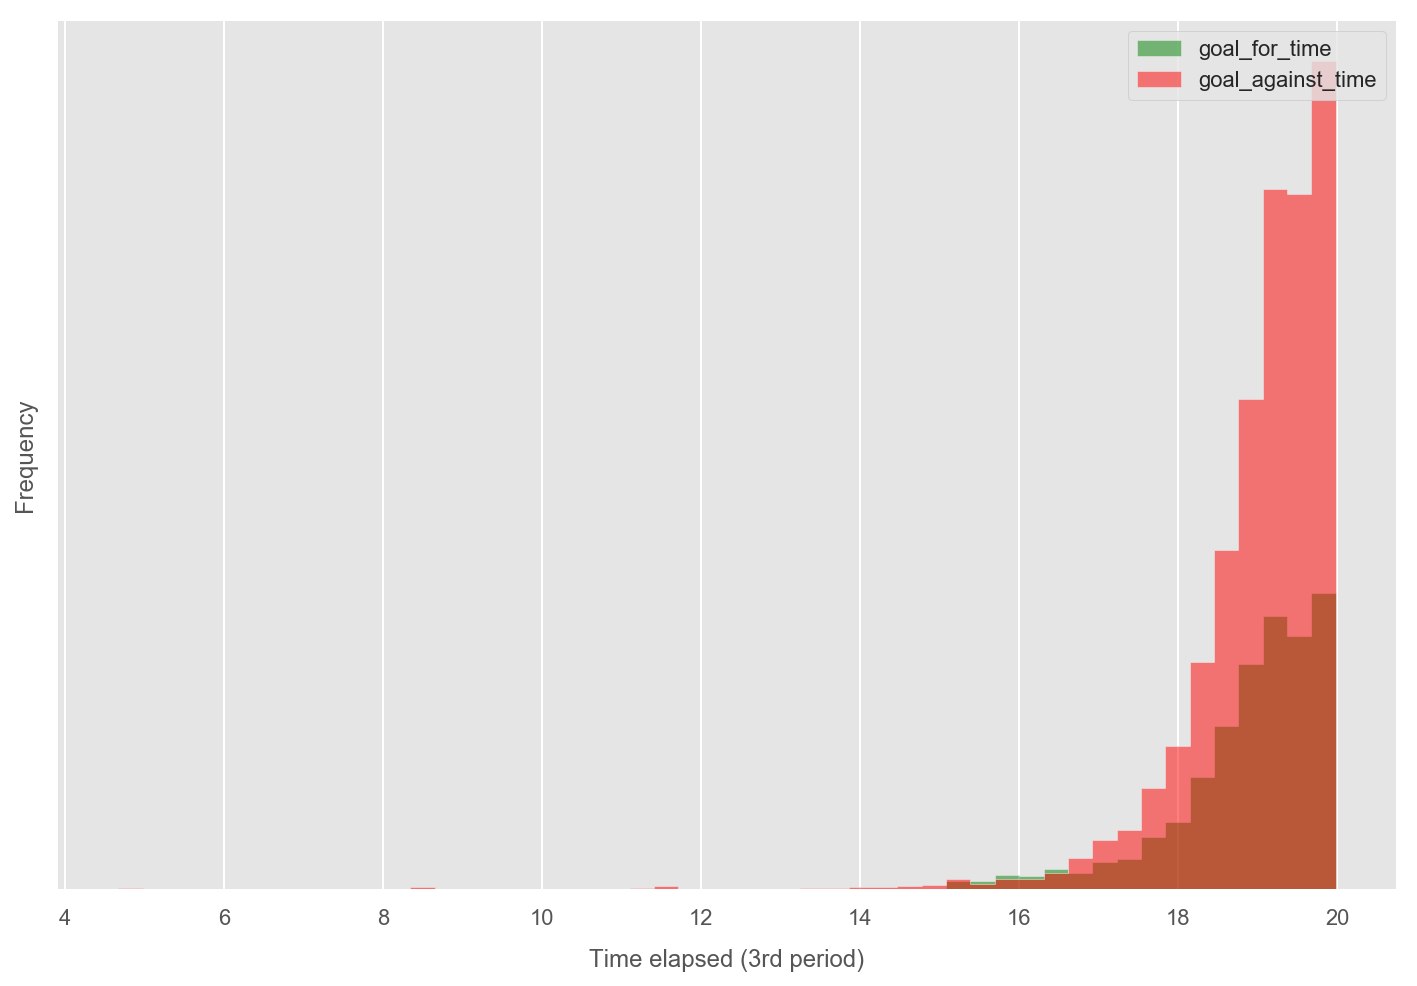

In [36]:
cols = ['goal_for_time', 'goal_against_time']
(df[cols].astype('timedelta64[s]') / 60)\
    .plot.hist(bins=50,
               alpha=0.5,
               color=['green', 'red'],
               histtype='stepfilled')
plt.xlabel('Time elapsed in 3rd period (minutes)')
plt.yticks([])
savefig(plt, '5_on_6_goals')

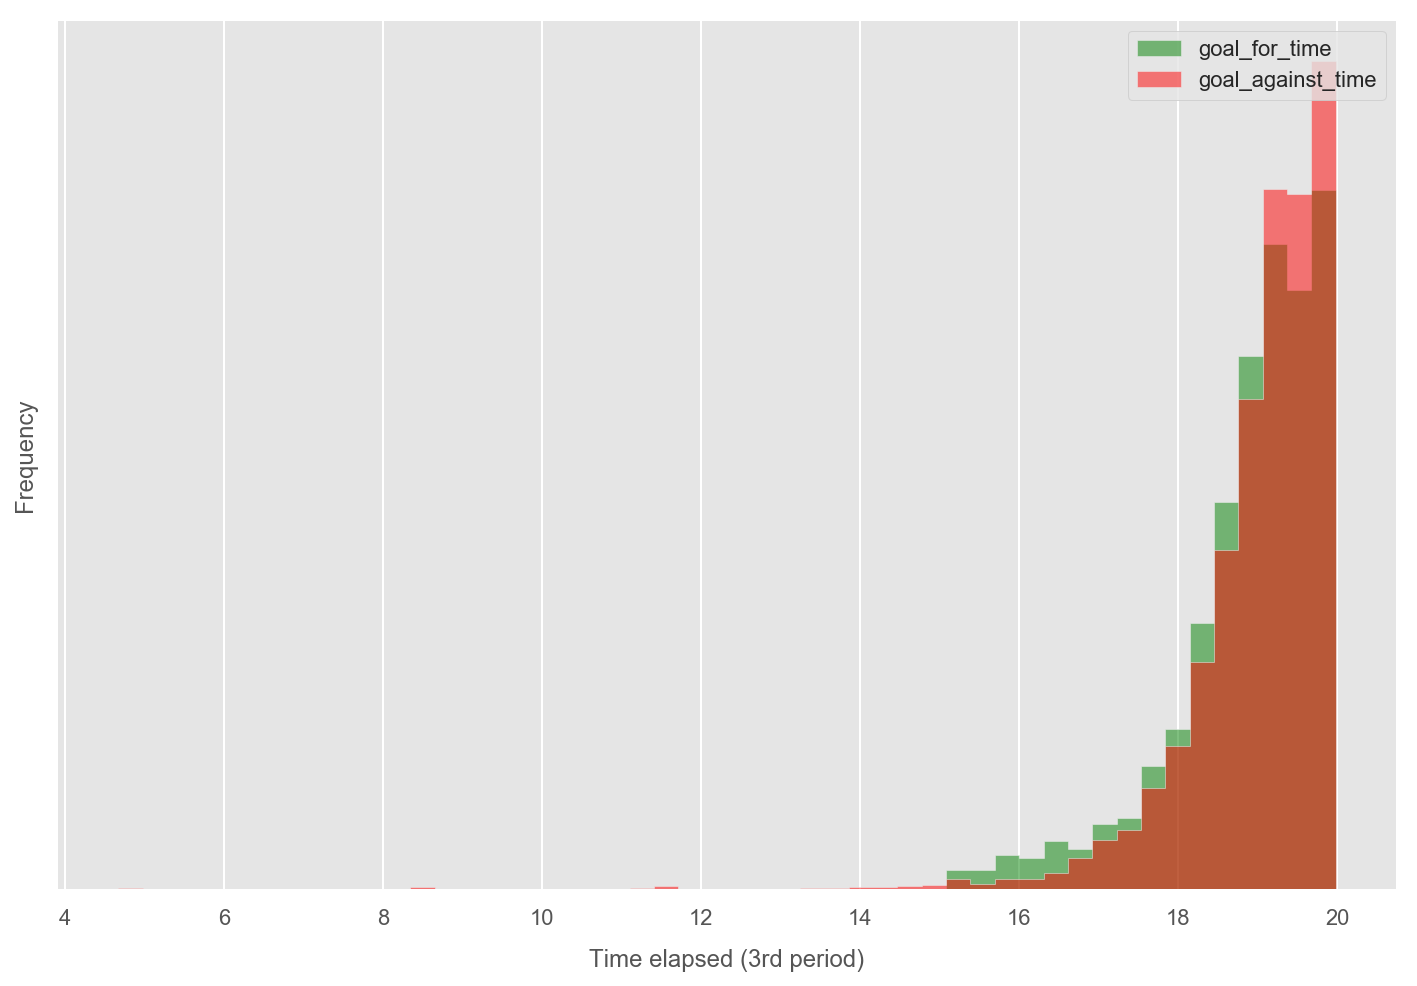

In [37]:
cols = ['goal_for_time', 'goal_against_time']
(df[cols].astype('timedelta64[s]') / 60)\
    .plot.hist(bins=50,
               alpha=0.5,
               density='normed',
               color=['green', 'red'],
               histtype='stepfilled')
plt.xlabel('Time elapsed in 3rd period (minutes)')
plt.yticks([])
savefig(plt, '5_on_6_goals_normed')

In [38]:
print('Number of goals found:')
(~df[['goal_for_time', 'goal_against_time']].isnull()).sum()

Number of goals found:


goal_for_time        270
goal_against_time    554
dtype: int64

In [39]:
print('Total goals found:')
(~df[['goal_for_time', 'goal_against_time']].isnull()).sum().sum()

Total goals found:


824

We also want to model the time between goalie pull and goal (i.e. the timedelta).

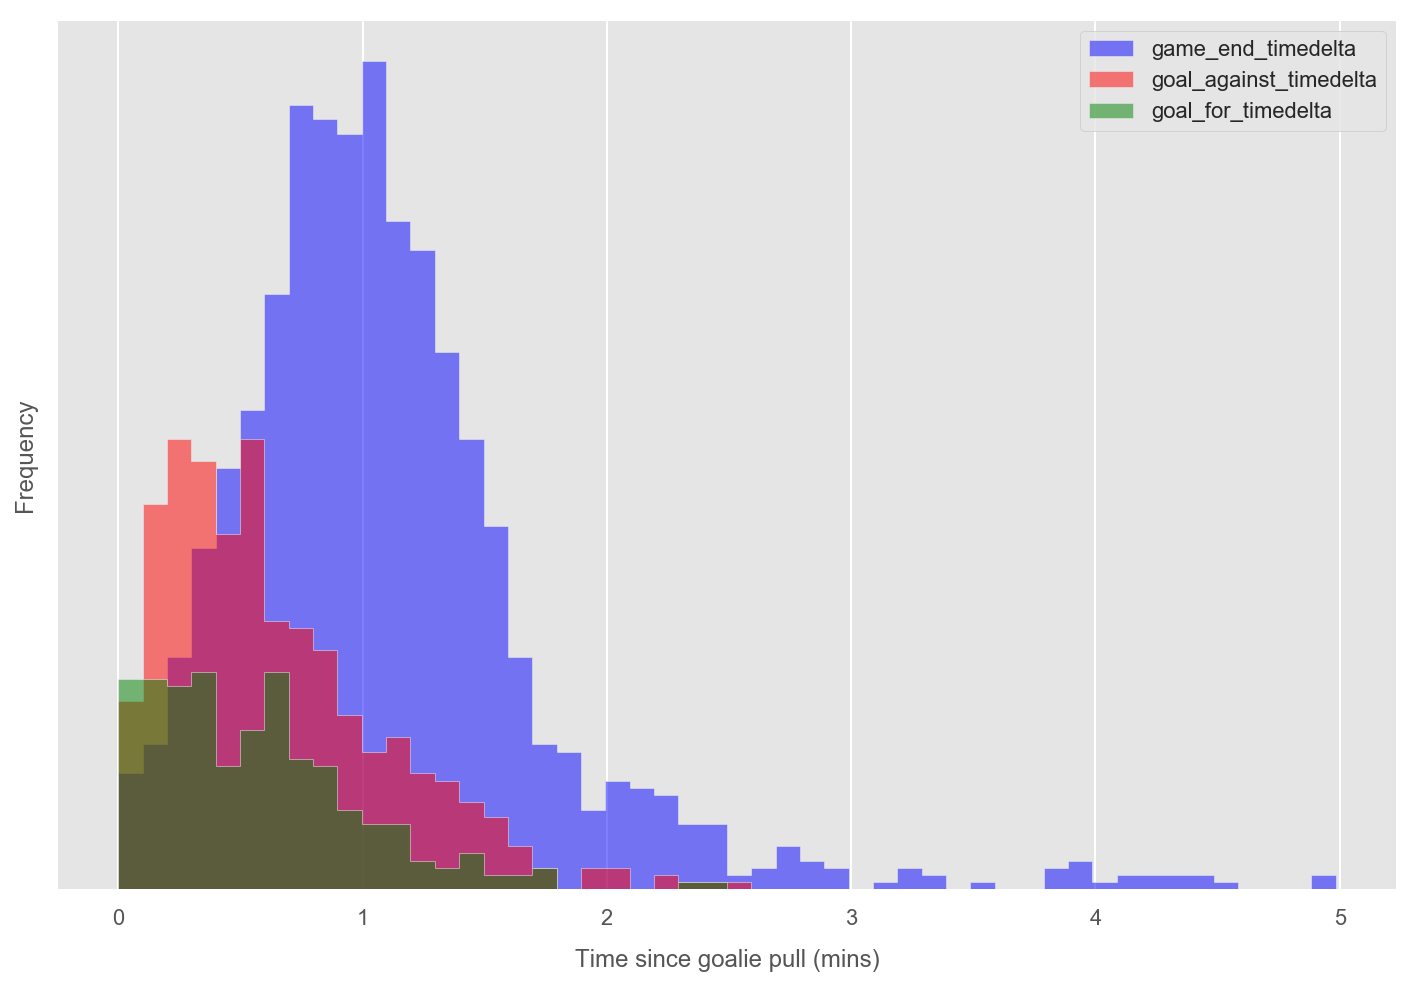

In [27]:
cols = ['game_end_timedelta', 'goal_against_timedelta', 'goal_for_timedelta', ]
(df[cols].astype('timedelta64[s]') / 60)\
    .plot.hist(bins=50, alpha=0.5,
               color=['blue', 'red','green'],
               histtype='stepfilled')
plt.xlabel('Time since goalie pull (minutes)')
plt.yticks([])
savefig(plt, '5_on_6_goalie_pull_outcomes')

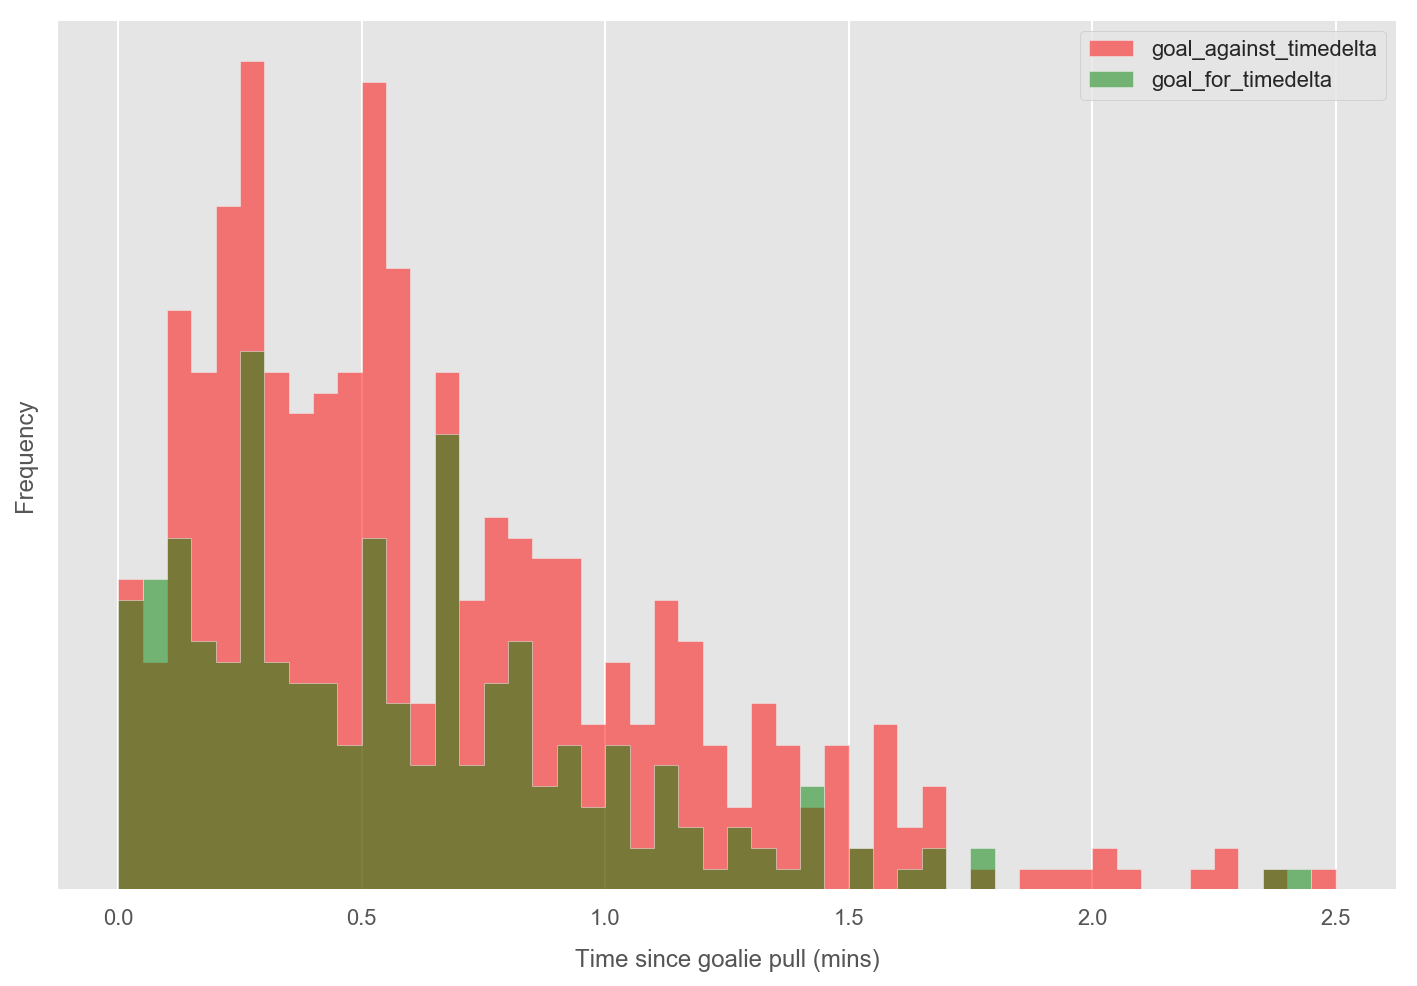

In [28]:
cols = ['goal_against_timedelta', 'goal_for_timedelta', ]
(df[cols].astype('timedelta64[s]') / 60)\
    .plot.hist(bins=50, alpha=0.5,
               color=['red', 'green',],
               histtype='stepfilled')
plt.xlabel('Time since goalie pull (minutes)')
plt.yticks([])
savefig(plt, '5_on_6_goalie_pull_goal_timedeltas')

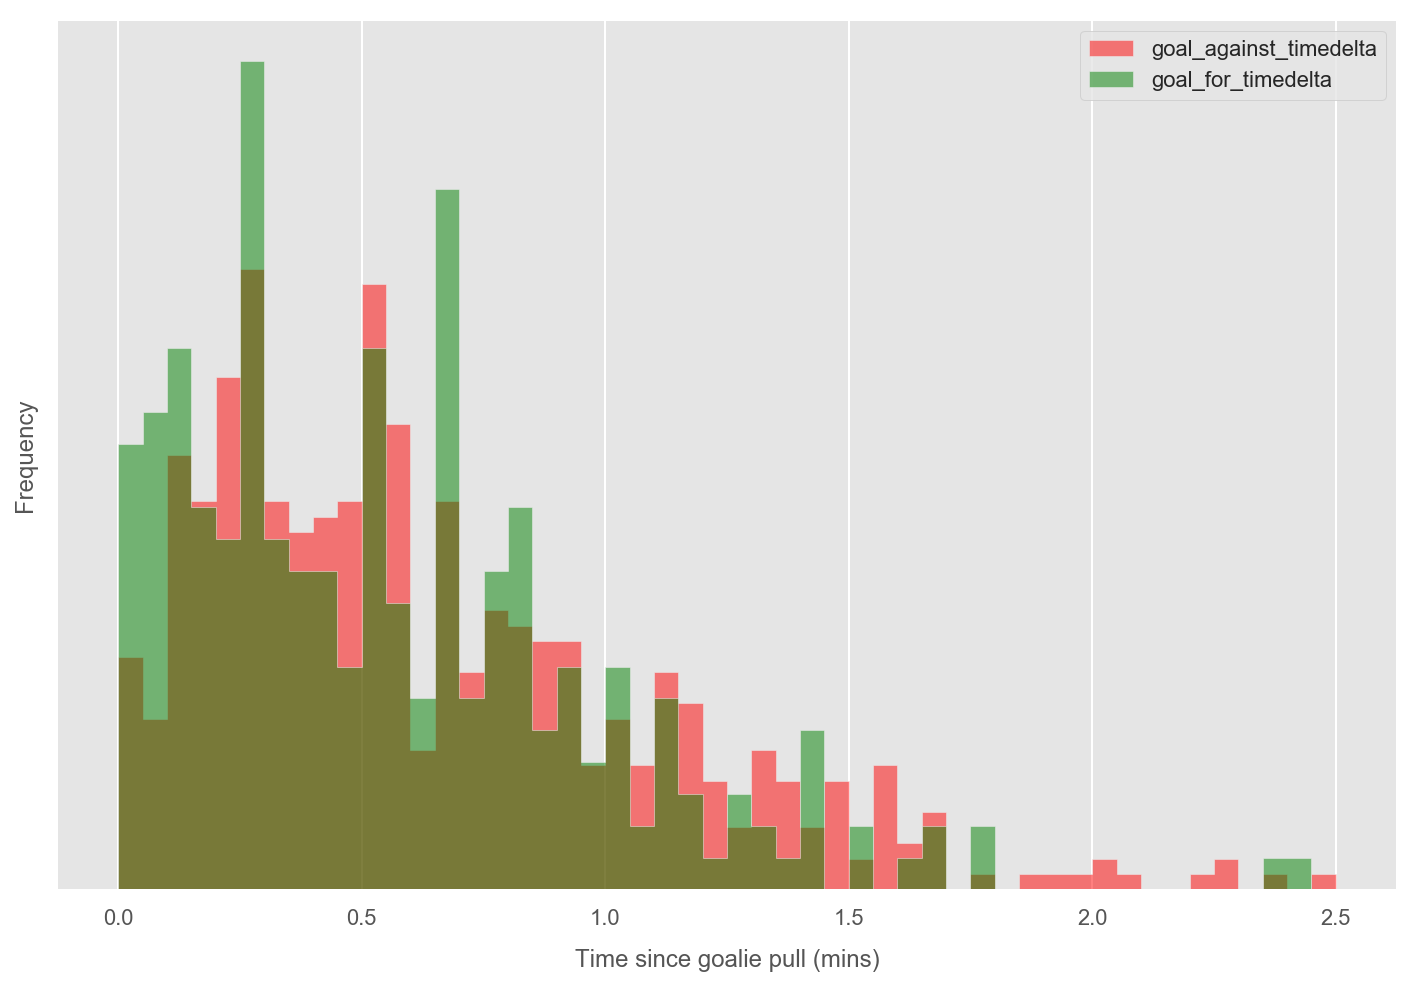

In [29]:
cols = ['goal_against_timedelta', 'goal_for_timedelta', ]
(df[cols].astype('timedelta64[s]') / 60)\
    .plot.hist(bins=50, alpha=0.5,
               density='normed',
               color=['red', 'green'],
               histtype='stepfilled')
plt.xlabel('Time since goalie pull (minutes)')
plt.yticks([])
savefig(plt, '5_on_6_goalie_pull_goal_timedeltas_normed')

The mean/median number of seconds until a goal (after pulling the goalie)

In [30]:
(df[cols].astype('timedelta64[s]')).mean()

goal_against_timedelta    38.348375
goal_for_timedelta        33.525926
dtype: float64

In [31]:
(df[cols].astype('timedelta64[s]')).median()

goal_against_timedelta    31.0
goal_for_timedelta        30.0
dtype: float64

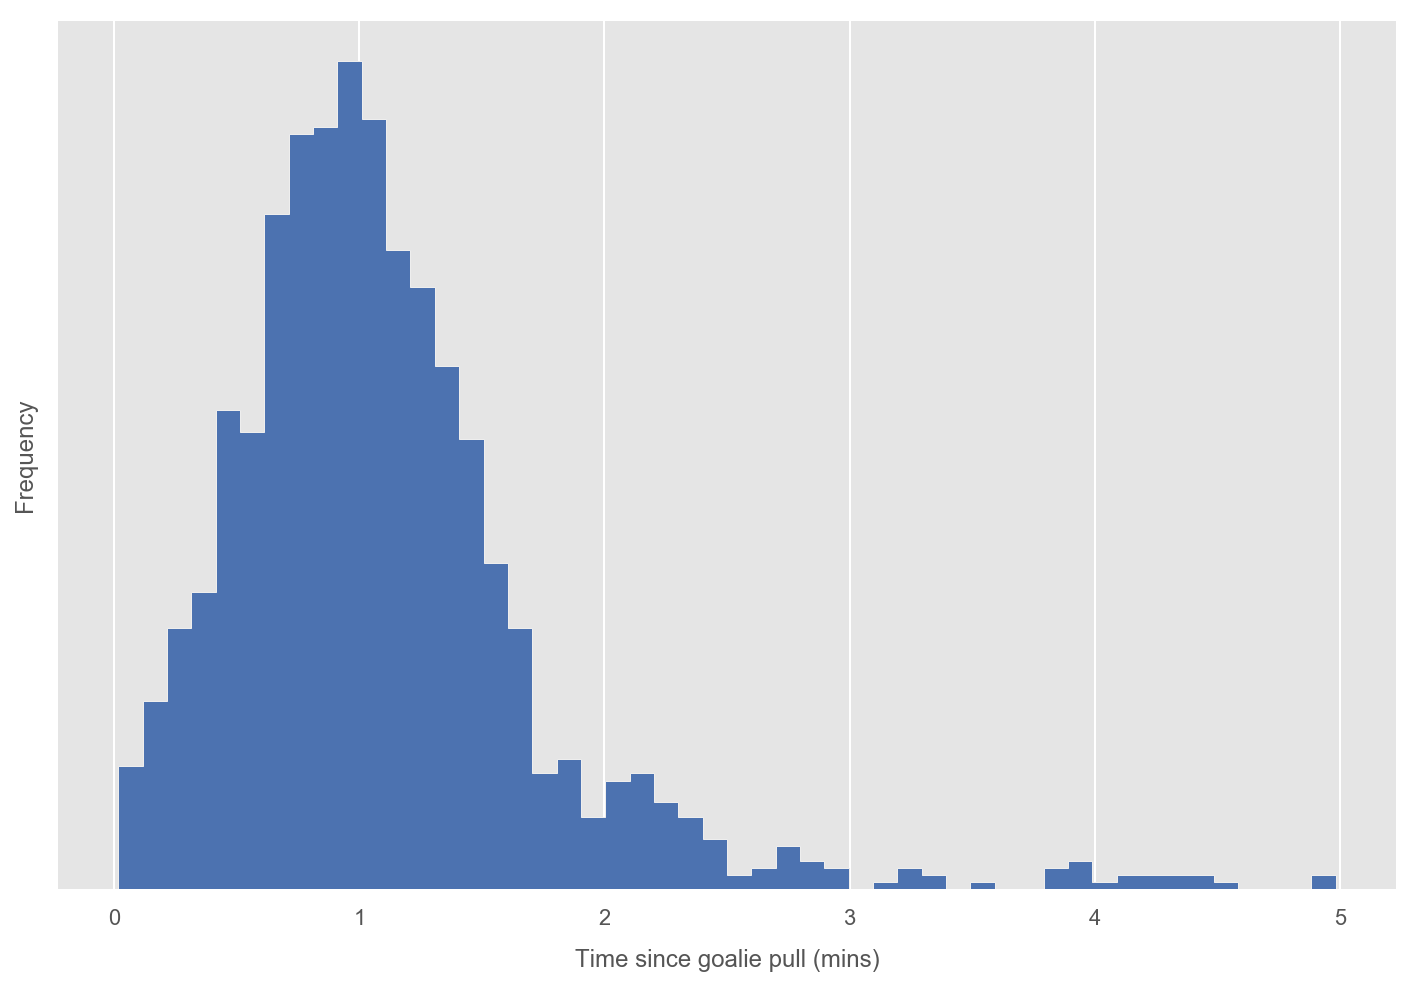

In [33]:
(df['game_end_timedelta'].astype('timedelta64[s]') / 60).plot.hist(bins=50, color='b', histtype='stepfilled')
plt.xlabel('Time since goalie pull (minutes)')
plt.yticks([])
savefig(plt, '5_on_6_game_end_timedeltas')

### Rough work

## Bugs

### *2019-02-01*

In [247]:
df = load_data()

Any non 3rd period pulls?

In [248]:
df[df['pull_period'] != 3]

,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,game_end_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta


Any bugs not in the last 15 minutes?

In [120]:
mask = df.pull_time < datetime.timedelta(seconds=15*60)
df[mask].shape[0]

0

I noticed some goal for timedelats less than 0.. which makes no sense. I'll have to look into that

In [121]:
mask = df.goal_for_time < datetime.timedelta(seconds=15*60)
df[mask]

,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,game_end_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta
576,20052006,591,NYI,2006-01-04,3,00:19:51,00:02:15,NaT,00:02:15,-1 days +23:42:24,NaT,-1 days +23:42:24


This game is weird... http://www.nhl.com/scores/htmlreports/20052006/PL020591.HTM

We'll drop this point before modeling.

In [150]:
df[df.goal_for_timedelta < datetime.timedelta(0)]

,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,game_end_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta
29,20032004,907,ATL,2004-02-21,3,00:19:14,00:18:59,NaT,00:20:00,-1 days +23:59:45,NaT,00:00:46
320,20032004,367,CHI,2003-12-03,3,00:18:19,00:18:01,NaT,00:19:43,-1 days +23:59:42,NaT,00:01:24
462,20032004,754,PHX,2004-01-27,3,00:19:22,00:17:52,NaT,00:19:54,-1 days +23:58:30,NaT,00:00:32
192,20062007,665,BOS,2007-01-13,3,00:17:23,00:17:13,NaT,00:19:33,-1 days +23:59:50,NaT,00:02:10


http://www.nhl.com/scores/htmlreports/20032004/PL020907.HTM

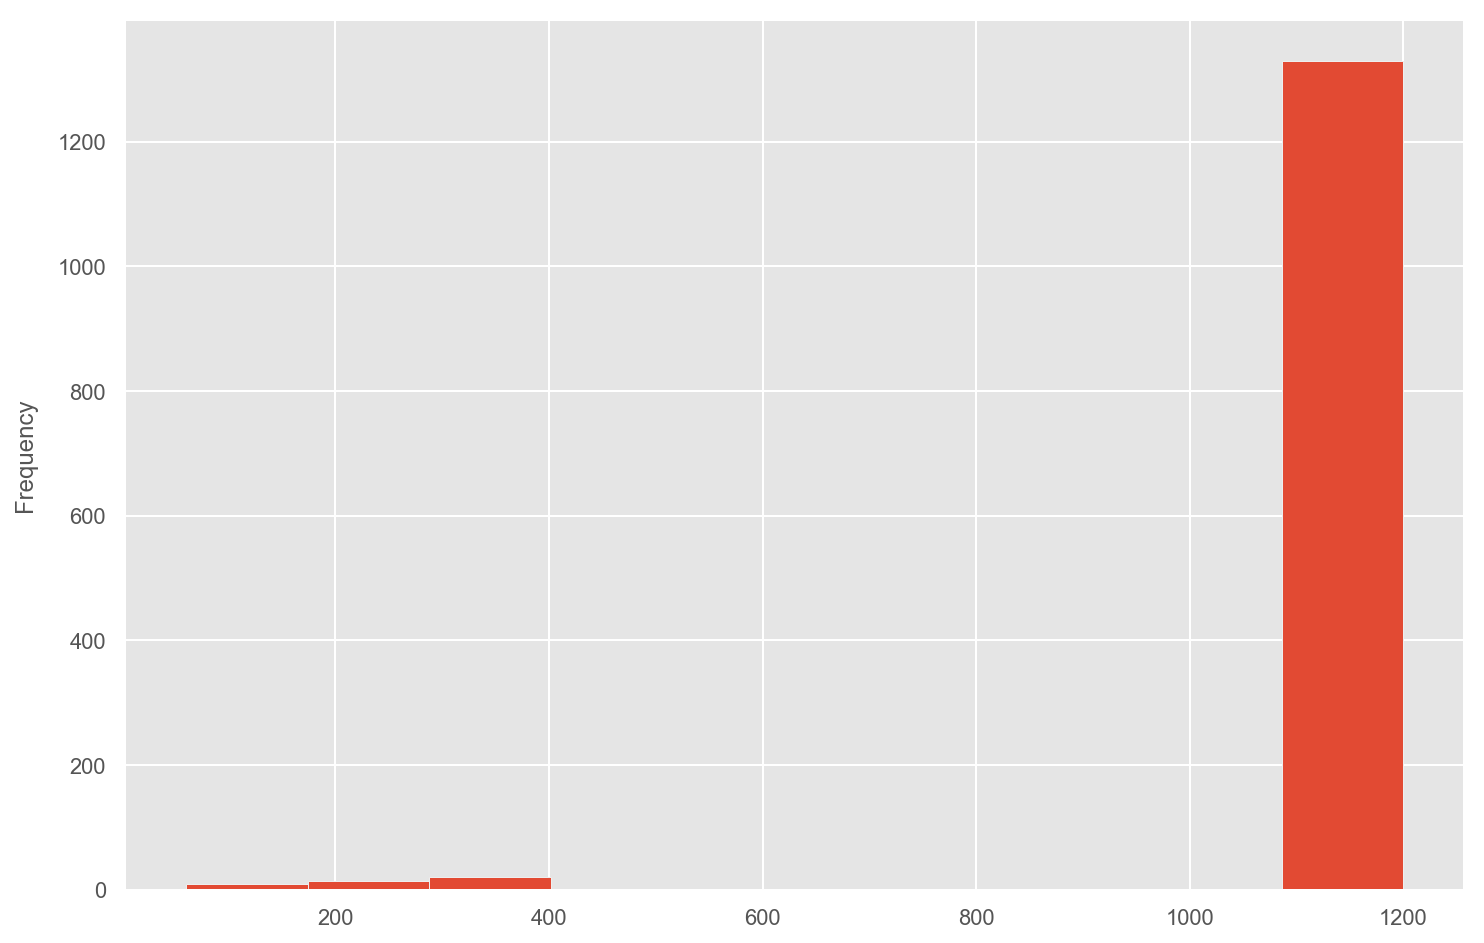

In [35]:
df.game_end_time.astype('timedelta64[s]').plot.hist()

Games should end at 20 mins. Let's throw out the early times (this must be overtime or something).

In [40]:
mask = df.game_end_time < datetime.timedelta(seconds=60*20)
mask.sum(), df.shape[0]

(1273, 2172)

In [41]:
mask = df.game_end_time < datetime.timedelta(seconds=60*15)
mask.sum(), df.shape[0]

(44, 2172)

Obviously the game will end at 20:00, this column corresponds to the last row parsed.

*2019-04-25*

In [43]:
df = load_data()

Any non 3rd period pulls?

In [44]:
df[df['pull_period'] != 3]

,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta,game_end_time
2,20072008,751,NSH,2008-01-24,1,00:00:00,NaT,NaT,NaT,NaT,00:00:44,00:00:44
3,20072008,1158,WSH,2008-03-27,1,00:00:00,NaT,NaT,NaT,NaT,00:00:52,00:00:52
4,20072008,696,CBJ,2008-01-17,1,00:00:00,NaT,NaT,NaT,NaT,00:01:27,00:01:27
5,20072008,946,STL,2008-02-24,1,00:00:00,NaT,NaT,NaT,NaT,00:00:47,00:00:47
6,20072008,1070,VAN,2008-03-13,1,00:00:00,NaT,NaT,NaT,NaT,00:01:14,00:01:14
9,20072008,570,DET,2007-12-29,1,00:00:00,NaT,NaT,NaT,NaT,00:00:16,00:00:16
12,20072008,618,ANA,2008-01-05,1,00:00:00,NaT,NaT,NaT,NaT,00:00:18,00:00:18
20,20072008,1084,EDM,2008-03-15,1,00:00:00,NaT,NaT,NaT,NaT,00:00:07,00:00:07
21,20072008,14,STL,2007-10-04,1,00:00:00,NaT,NaT,NaT,NaT,00:00:09,00:00:09
23,20072008,526,VAN,2007-12-22,1,00:00:00,NaT,NaT,NaT,NaT,00:00:12,00:00:12


In [46]:
df.pull_period.value_counts().sort_index()

1      205
2      340
3    14532
4     1453
5     1336
Name: pull_period, dtype: int64

None of these make sense.. we'll want to drop them

Any bugs not in the last 15 minutes?

In [47]:
mask = df.pull_time < datetime.timedelta(seconds=15*60)
df[mask].shape[0]

4241

In [48]:
df[mask]

,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta,game_end_time
2,20072008,751,NSH,2008-01-24,1,00:00:00,NaT,NaT,NaT,NaT,00:00:44,00:00:44
3,20072008,1158,WSH,2008-03-27,1,00:00:00,NaT,NaT,NaT,NaT,00:00:52,00:00:52
4,20072008,696,CBJ,2008-01-17,1,00:00:00,NaT,NaT,NaT,NaT,00:01:27,00:01:27
5,20072008,946,STL,2008-02-24,1,00:00:00,NaT,NaT,NaT,NaT,00:00:47,00:00:47
6,20072008,1070,VAN,2008-03-13,1,00:00:00,NaT,NaT,NaT,NaT,00:01:14,00:01:14
9,20072008,570,DET,2007-12-29,1,00:00:00,NaT,NaT,NaT,NaT,00:00:16,00:00:16
12,20072008,618,ANA,2008-01-05,1,00:00:00,NaT,NaT,NaT,NaT,00:00:18,00:00:18
20,20072008,1084,EDM,2008-03-15,1,00:00:00,NaT,NaT,NaT,NaT,00:00:07,00:00:07
21,20072008,14,STL,2007-10-04,1,00:00:00,NaT,NaT,NaT,NaT,00:00:09,00:00:09
22,20072008,422,MTL,2007-12-08,3,00:10:00,NaT,NaT,NaT,NaT,00:10:00,00:20:00


I noticed some goal for timedelats less than 0.. which makes no sense. I'll have to look into that

In [49]:
mask = df.goal_for_time < datetime.timedelta(seconds=15*60)
df[mask]

,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta,game_end_time
557,20052006,591,NYI,2006-01-04,3,00:19:51,00:02:15,NaT,-1 days +23:42:24,NaT,NaT,NaT
65,20072008,562,OTT,2007-12-29,2,00:10:05,00:10:06,NaT,00:00:01,NaT,NaT,NaT
111,20072008,175,MTL,2007-11-01,1,00:08:36,00:08:53,NaT,00:00:17,NaT,NaT,NaT
19,20082009,588,N.J,2009-01-06,3,00:11:40.500000,00:12:12,NaT,00:00:31.500000,NaT,NaT,NaT
71,20082009,1042,BUF,2009-03-17,1,00:03:57,00:04:02,NaT,00:00:05,NaT,NaT,NaT
89,20082009,1167,PHI,2009-04-04,2,00:02:56,00:02:58,NaT,00:00:02,NaT,NaT,NaT
95,20082009,959,OTT,2009-03-05,2,00:03:57.500000,00:04:03,NaT,00:00:05.500000,NaT,NaT,NaT
50,20092010,907,PHI,2010-02-13,3,00:10:53,00:10:53,NaT,00:00:00,NaT,00:09:07,00:20:00
69,20092010,815,CGY,2010-01-30,1,00:13:06,00:13:20,NaT,00:00:14,NaT,NaT,NaT
75,20092010,1123,TOR,2010-03-28,2,00:14:30.500000,00:14:35,NaT,00:00:04.500000,NaT,NaT,NaT


We'll have to drop these as well

In [50]:
df[df.goal_for_timedelta < datetime.timedelta(0)]

,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta,game_end_time
557,20052006,591,NYI,2006-01-04,3,00:19:51,00:02:15,NaT,-1 days +23:42:24,NaT,NaT,NaT
572,20092010,916,NYR,2010-02-14,2,00:10:00,00:01:40,NaT,-1 days +23:51:40,NaT,NaT,NaT
653,20092010,605,L.A,2009-12-31,2,00:10:00,00:03:17,NaT,-1 days +23:53:17,NaT,NaT,NaT
1044,20102011,1055,PHI,2011-03-17,2,00:19:57,00:18:32,NaT,-1 days +23:58:35,NaT,NaT,NaT
27,20112012,244,CAR,2011-11-14,2,00:12:44,00:04:36,NaT,-1 days +23:51:52,NaT,NaT,NaT
48,20112012,585,TOR,2012-01-05,2,00:10:00,00:01:22,NaT,-1 days +23:51:22,NaT,NaT,NaT
924,20112012,217,FLA,2011-11-10,2,00:10:00,00:04:53,NaT,-1 days +23:54:53,NaT,NaT,NaT
1197,20112012,728,STL,2012-01-24,3,00:10:00,00:05:04,NaT,-1 days +23:55:04,NaT,NaT,NaT
1529,20112012,292,PHX,2011-11-21,2,00:10:00,00:07:34,NaT,-1 days +23:57:34,NaT,NaT,NaT
514,20122013,450,PHX,2013-03-21,2,00:10:00,00:02:26,NaT,-1 days +23:52:26,NaT,NaT,NaT


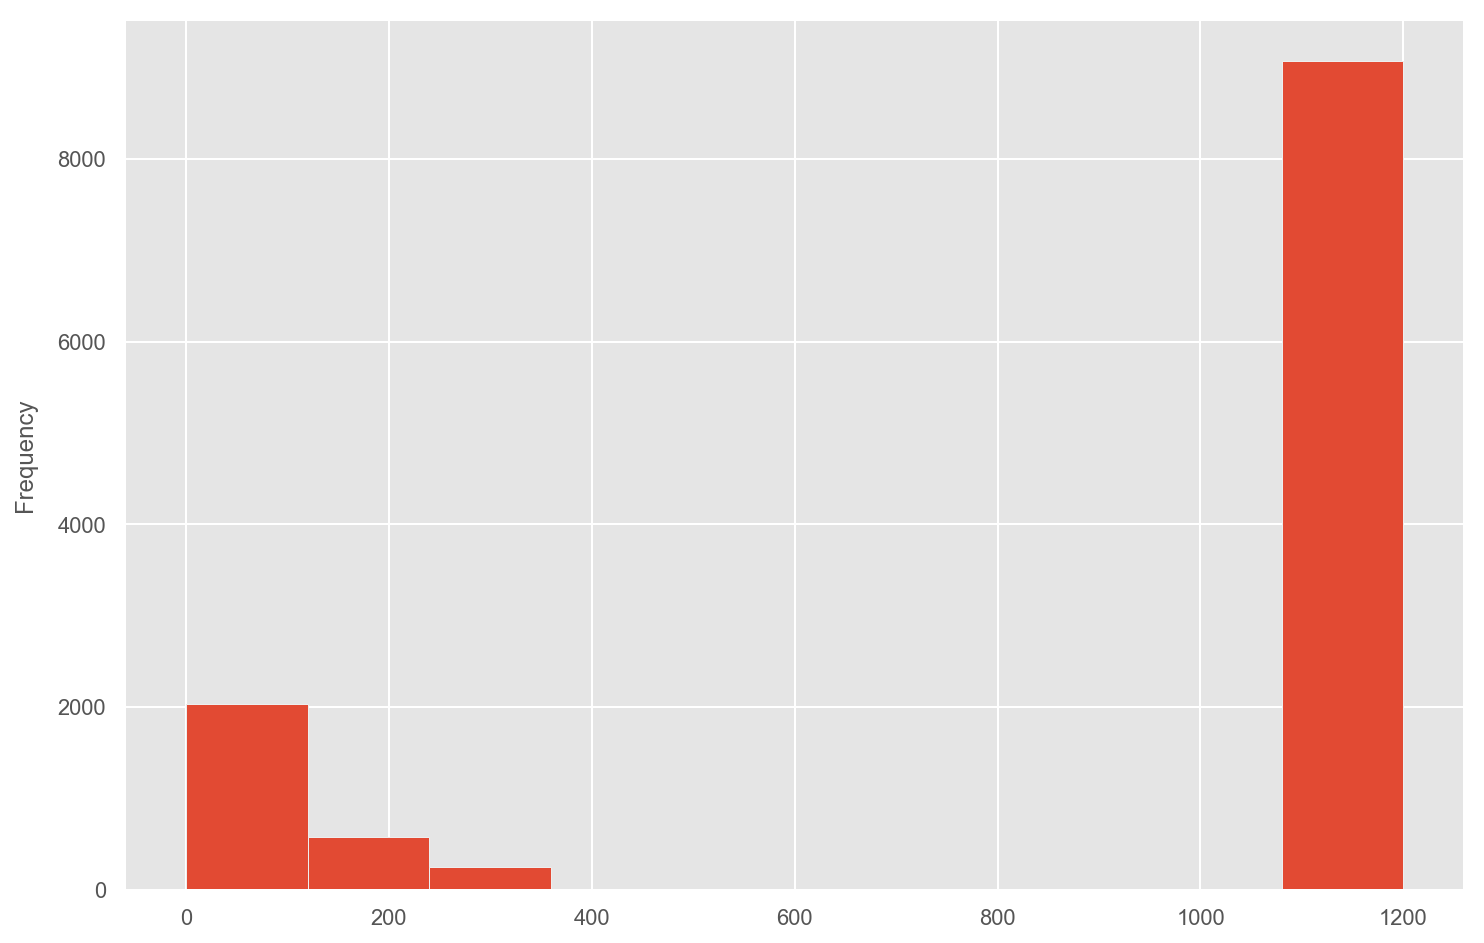

In [51]:
df.game_end_time.astype('timedelta64[s]').plot.hist()

Games should end at 20 mins. Let's throw out the early times (this must be overtime or something).

Obviously the game will end at 20:00, this column corresponds to the last row parsed.

Let's look at the spike in goalie pull times around 10 minutes

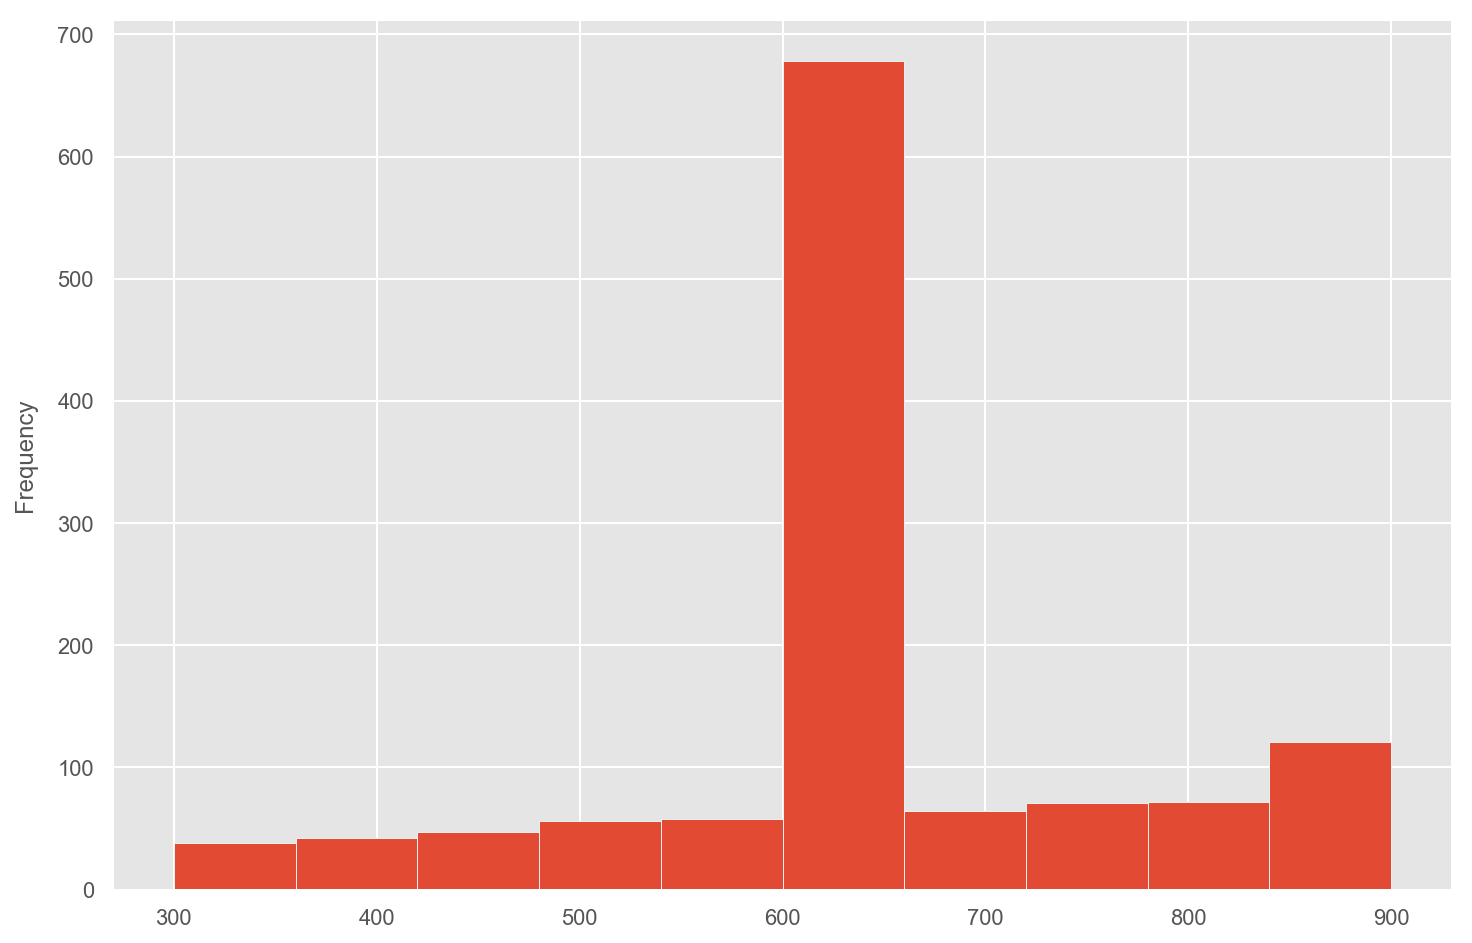

In [60]:
mask = (df.pull_time <= datetime.timedelta(seconds=15*60))\
        & (df.pull_time >= datetime.timedelta(seconds=5*60))
df[mask].pull_time.astype('timedelta64[s]').plot.hist()

In [62]:
df[df.pull_time == datetime.timedelta(seconds=10*60)]

,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta,game_end_time
22,20072008,422,MTL,2007-12-08,3,00:10:00,NaT,NaT,NaT,NaT,00:10:00,00:20:00
91,20082009,914,S.J,2009-02-26,3,00:10:00,NaT,NaT,NaT,NaT,00:10:00,00:20:00
129,20082009,338,MTL,2008-11-29,3,00:10:00,NaT,NaT,NaT,NaT,00:10:00,00:20:00
13,20092010,747,NYR,2010-01-21,3,00:10:00,NaT,NaT,NaT,NaT,00:10:00,00:20:00
28,20092010,1158,PHI,2010-04-02,2,00:10:00,NaT,NaT,NaT,NaT,00:10:00,00:20:00
54,20092010,1174,ANA,2010-04-03,2,00:10:00,00:18:28,NaT,00:08:28,NaT,NaT,NaT
71,20092010,1089,VAN,2010-03-23,3,00:10:00,NaT,NaT,NaT,NaT,00:10:00,00:20:00
91,20092010,550,MTL,2009-12-23,3,00:10:00,NaT,NaT,NaT,NaT,00:10:00,00:20:00
123,20092010,198,BOS,2009-11-03,2,00:10:00,NaT,NaT,NaT,NaT,00:10:00,00:20:00
151,20092010,970,PHI,2010-03-07,3,00:10:00,NaT,NaT,NaT,NaT,00:10:00,00:20:00


### *2019-04-26*

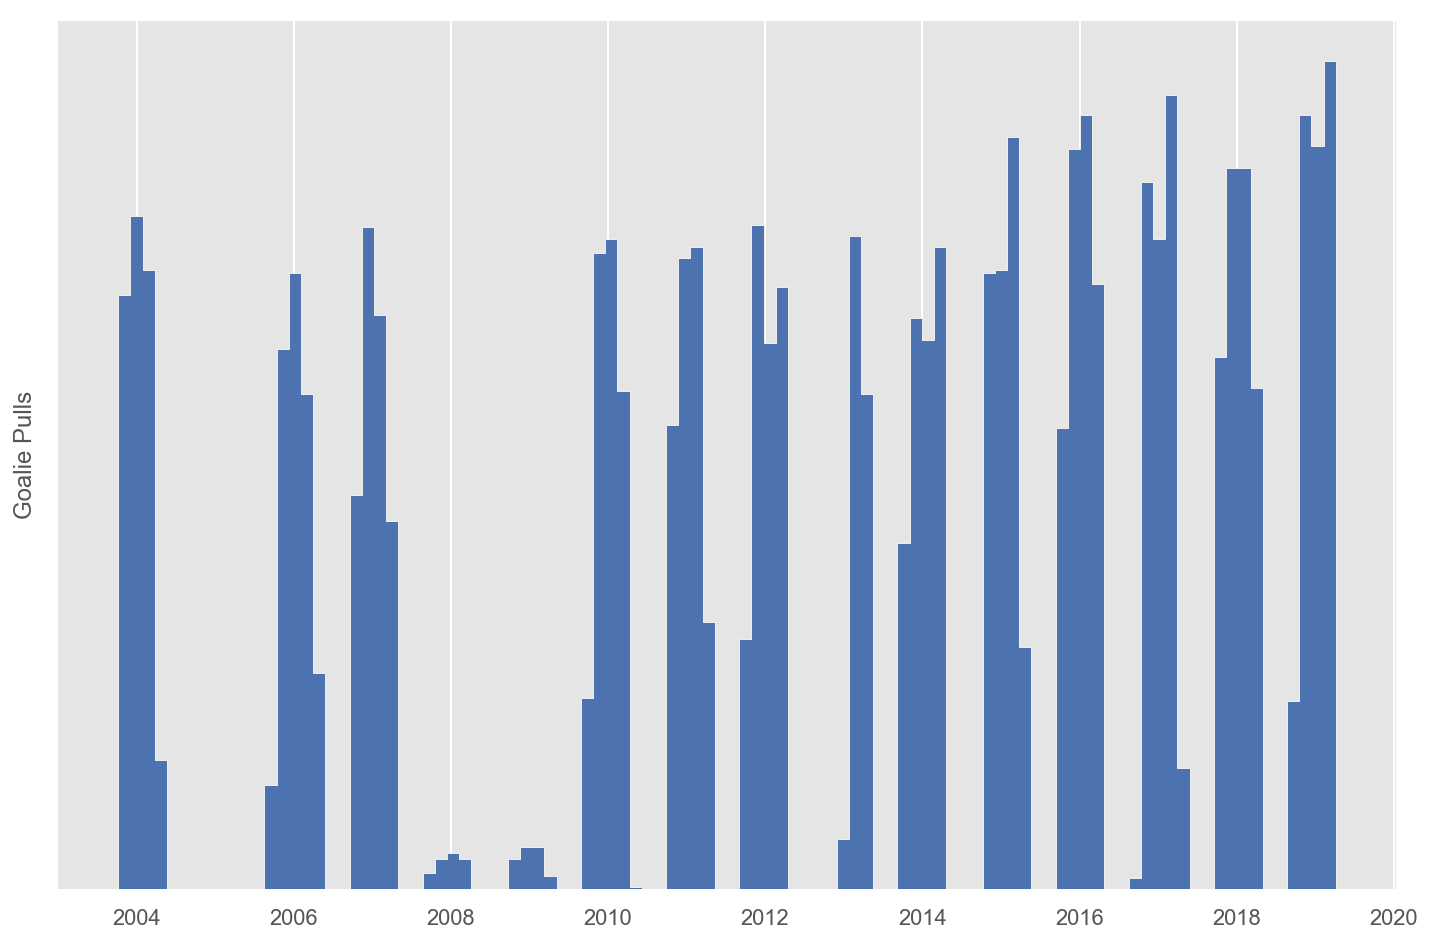

In [39]:
plt.ylabel('Goalie Pulls')
plt.yticks([])
df.date.hist(
    color='b',
    bins=100,
    histtype='stepfilled')
# savefig(plt, 'goalie_pulls_2003-2019')

In [40]:
df.groupby('season').size()

season
20032004    716
20052006    702
20062007    710
20072008     41
20082009     46
20092010    703
20102011    712
20112012    733
20122013    426
20132014    749
20142015    792
20152016    917
20162017    811
20172018    879
20182019    900
dtype: int64

Too few pulls from 2007-2009. I wonder how many HTML files I have for each

In [44]:
!ls ../../data/raw/html/

20032004 20052006 20072008 20092010 20112012 20132014 20152016 20172018
20042005 20062007 20082009 20102011 20122013 20142015 20162017 20182019


In [100]:
import os, glob
def nested_count(folder_path, level=0):
    for folder in sorted(glob.glob('{}/'.format(os.path.join(folder_path, '*')))):
        print('{:}{:}: {:,}'.format('    '*level, os.path.split(os.path.split(folder)[-2])[-1], len(glob.glob(os.path.join(folder, '*')))))
        nested_count(folder, level+1)
nested_count('../../data/')

external: 0
interim: 0
processed: 2
    csv: 16
        tmp: 0
    pkl: 16
        tmp: 17
raw: 1
    html: 16
        20032004: 1,230
        20042005: 0
        20052006: 1,228
        20062007: 1,230
        20072008: 1,230
        20082009: 1,230
        20092010: 1,230
        20102011: 1,230
        20112012: 1,230
        20122013: 720
        20132014: 1,230
        20142015: 1,230
        20152016: 1,230
        20162017: 1,230
        20172018: 1,271
        20182019: 1,271


I will need to look at the parsing for 2007-2009. Something is up

In [102]:
df_ = df[(df.season == '20072008') | (df.season == '20082009')]

In [104]:
len(df_)

87

In [106]:
df_.label.value_counts()

no_goals        51
goal_against    27
goal_for         9
Name: label, dtype: int64

It turns out that some tables just aren't being parsed properly... I need to use html.parser instead of lxml in some cases

### *2019-04-30*

Text(0, 0.5, 'Total Goalie Pulls')

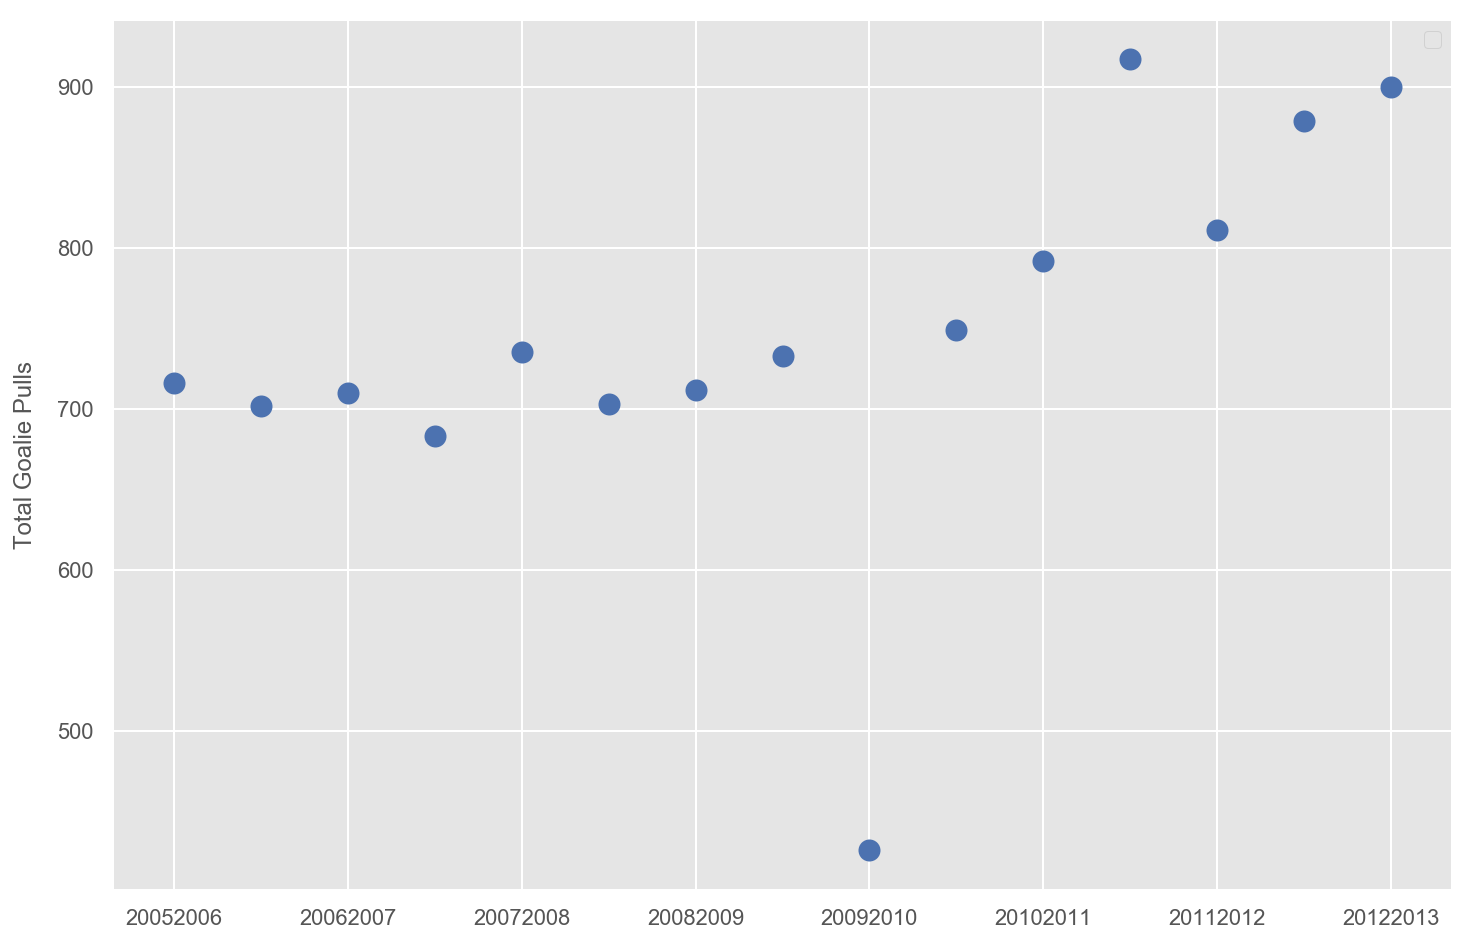

In [244]:
fig, ax = plt.subplots()
s = df.groupby('season').size().sort_index(ascending=True).rename('counts').reset_index()
ax = s.plot(marker='o', lw=0, ax=ax, color='b', ms=10)
ax.set_xticklabels(s.season.tolist());
# ax.set_ylim(600, 1100)
plt.legend([])
plt.ylabel('Total Goalie Pulls')
# savefig('goalie_pulls_by_season')

In [319]:
label_map

{'0': '20032004',
 '1': '20052006',
 '2': '20062007',
 '3': '20072008',
 '4': '20082009',
 '5': '20092010',
 '6': '20102011',
 '7': '20112012',
 '8': '20122013',
 '9': '20132014',
 '10': '20142015',
 '11': '20152016',
 '12': '20162017',
 '13': '20172018',
 '14': '20182019'}

In [320]:
xticks

['',
 '20032004',
 '20062007',
 '20082009',
 '20102011',
 '20122013',
 '20142015',
 '20162017',
 '20182019']

ValueError: cannot reindex from a duplicate axis

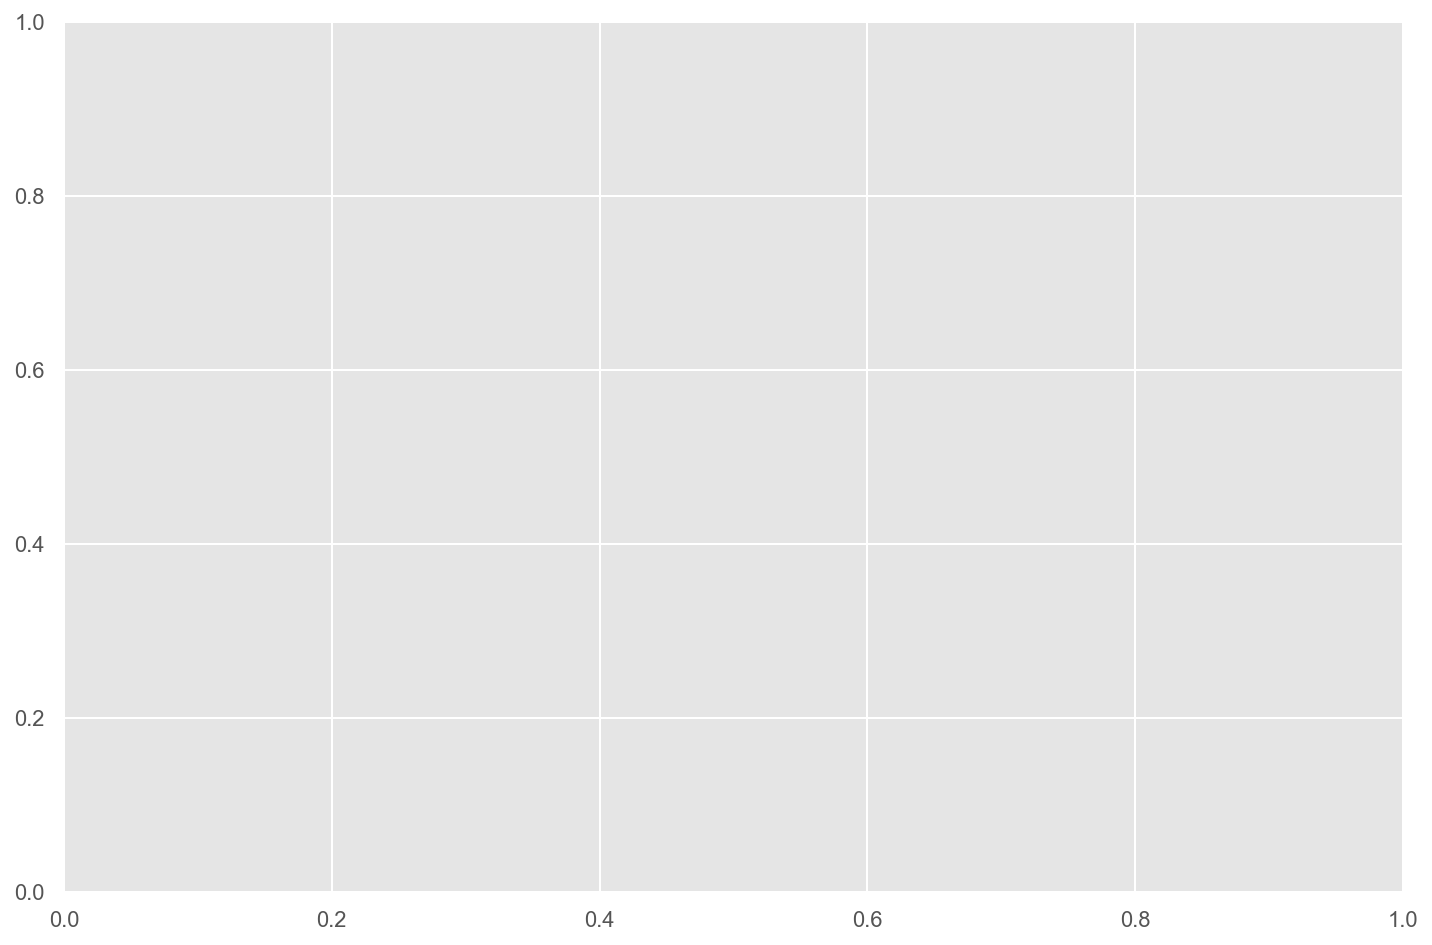

In [335]:
fig, ax = plt.subplots()
iterables = zip(['orange', 'red', 'green'],
                ['no_goals', 'goal_against', 'goal_for'])

axes = []
for c, label in iterables:
    m = df.label==label
#     m = m & (df.season != '20122013')
    df_ = df[m].copy()
    df_.loc[(df.season == '20122013'), label] = 0
    s = df_.groupby('season').size().sort_index(ascending=True).rename(label).reset_index()
    s.plot(marker='o', lw=0, ax=ax, ms=10, color=c, label=label)
    plt.legend()

    
ax = plt.gca()
ax.set_ylim(0, 600)
ax.set_xlim(0, 15)

label_map = {str(i): season for i, season in enumerate(df.season.drop_duplicates().sort_values(ascending=True).tolist())}
xticks = [label_map.get(str(round(tick)), '') for tick in ax.get_xticks().tolist()]
ax.set_xticklabels(xticks)
plt.ylabel('Goalie Pulls')

# savefig('goalie_pull_outcomes_by_season')

Text(0, 0.5, 'Goalie Pulls')

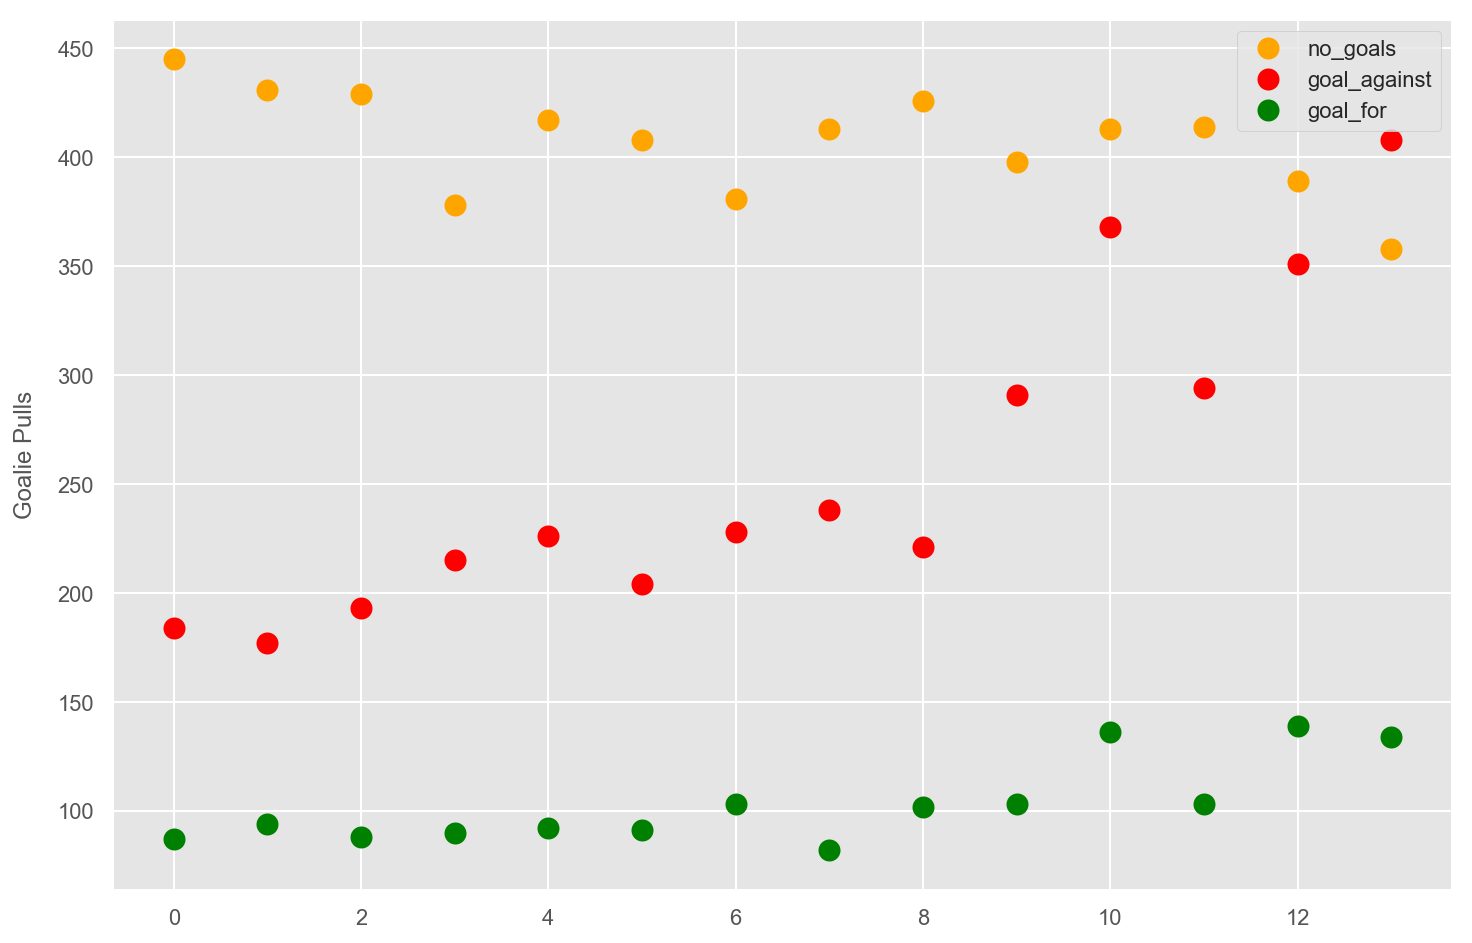

Something is up with 2009, where I don't seem to collect enough data.

The issue is my labels. That should be the 2012/2013 season, which was shortened by a lockout

In [286]:
ax

In [299]:
[t.get_text() for t in ax.get_xticklabels()]

['',
 '20032004',
 '20062007',
 '20082009',
 '20102011',
 '20122013',
 '20142015',
 '20162017',
 '20182019',
 '']

In [298]:
for tick in ax.get_xticklabels():
    tick.set_text(label_map.get(tick.get_text(), ''))

In [290]:
tick = ax.get_xticklabels()[0]

In [293]:
tick.set_text('')

In [296]:
label_map

{'0': '20032004',
 '1': '20052006',
 '2': '20062007',
 '3': '20072008',
 '4': '20082009',
 '5': '20092010',
 '6': '20102011',
 '7': '20112012',
 '8': '20122013',
 '9': '20132014',
 '10': '20142015',
 '11': '20152016',
 '12': '20162017',
 '13': '20172018',
 '14': '20182019'}

In [ ]:
label_map = {str(i): season for i, season in enumerate(df.groupby('season').size().sort_index(ascending=True).index.tolist())}
# xticklabels = [label_map.get(t.get_text(), '') for t in ax.get_xticklabels()]
# ax.set_xticklabels(xticklabels)


# print([t.get_text() for t in ax.get_xticklabels()])

# ticks = [t.get_text() for t in ax.get_xticklabels()]
# ax.set_xticklabels(ticks)


In [ ]:
fig, ax = plt.subplots()
iterables = zip(['orange', 'red', 'green'],
                ['no_goals', 'goal_against', 'goal_for'])

axes = []
for c, label in iterables:
    m = df.label==label
    s = df[m].groupby('season').size().sort_index(ascending=True).rename(label).reset_index()
    axes.append(s.plot(marker='o', lw=0, ax=ax, ms=10, color=c, label=label))
    plt.legend()

ax.set_xticklabels(s.season.tolist());
ax.set_ylim(0, 600)
plt.ylabel('Total Counts')
# savefig('goalie_pull_outcomes_by_season')

['', '', '', '', '', '', '', '', '', '']


Text(0, 0.5, 'Total Counts')

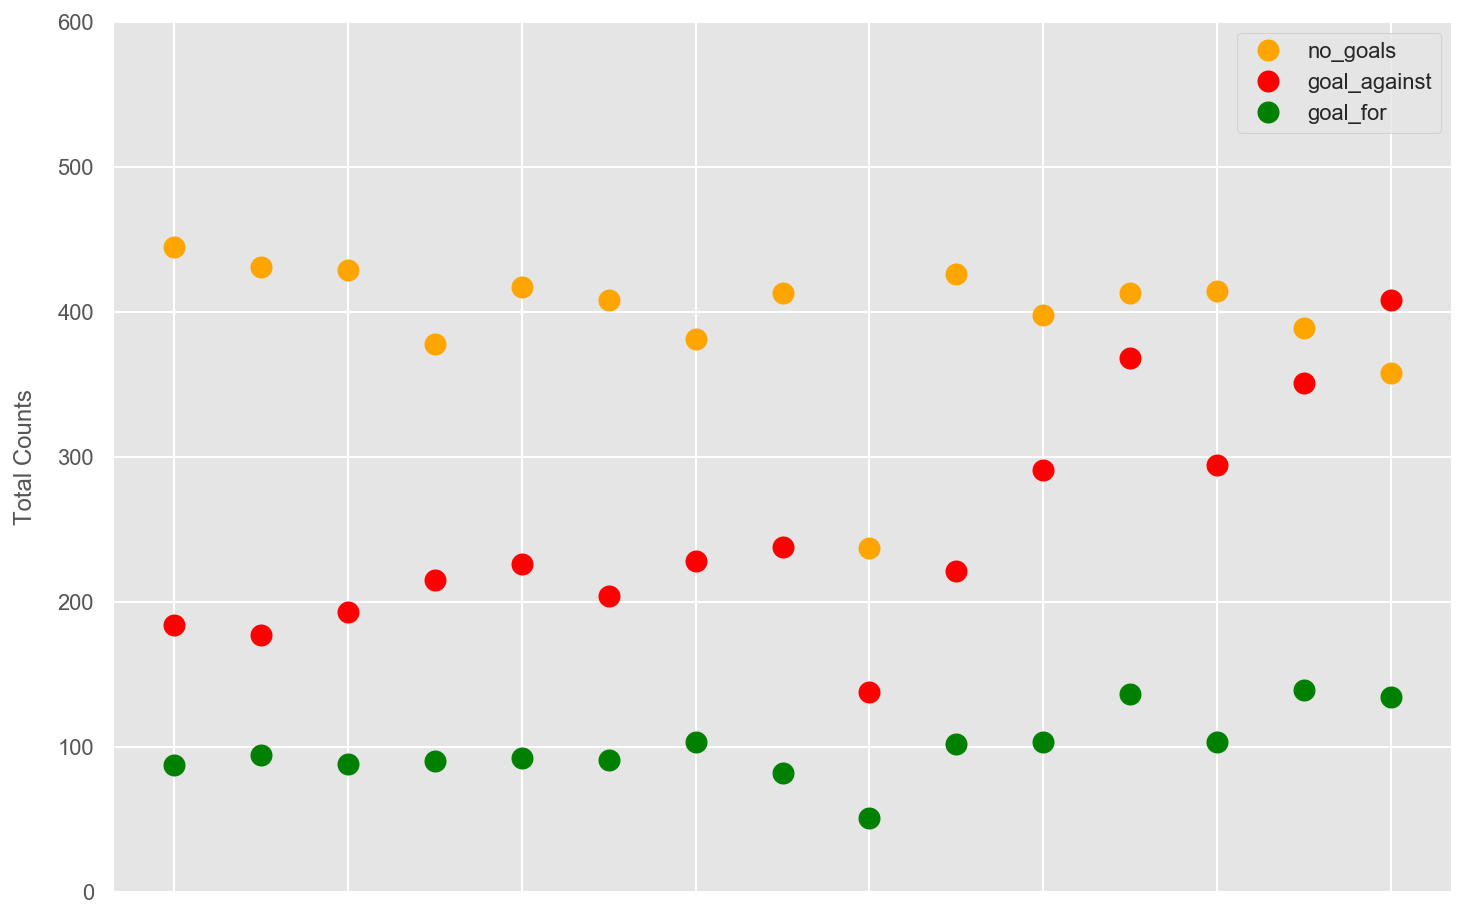

In [284]:
# fig, ax = plt.subplots()
# iterables = zip(['orange', 'red', 'green'],
#                 ['no_goals', 'goal_against', 'goal_for'])

# axes = []
# for c, label in iterables:
#     m = df.label==label
#     s = df[m].groupby('season').size().sort_index(ascending=True).rename(label).reset_index()
#     s.plot(marker='o', lw=0, ax=ax, ms=10, color=c, label=label)
#     plt.legend()



# ax.set_ylim(0, 600)
label_map = {str(i): season for i, season in enumerate(df.groupby('season').size().sort_index(ascending=True).index.tolist())}
# xticklabels = [label_map.get(t.get_text(), '') for t in ax.get_xticklabels()]
# ax.set_xticklabels(xticklabels)


# print([t.get_text() for t in ax.get_xticklabels()])

# ticks = [t.get_text() for t in ax.get_xticklabels()]
# ax.set_xticklabels(ticks)
# plt.ylabel('Total Counts')
# # savefig('goalie_pull_outcomes_by_season')

In [267]:
label_map

{'0': '20032004',
 '1': '20052006',
 '2': '20062007',
 '3': '20072008',
 '4': '20082009',
 '5': '20092010',
 '6': '20102011',
 '7': '20112012',
 '8': '20122013',
 '9': '20132014',
 '10': '20142015',
 '11': '20152016',
 '12': '20162017',
 '13': '20172018',
 '14': '20182019'}

In [273]:
[t.get_text() for t in ax.get_xticklabels()]

['−2', '0', '2', '4', '6', '8', '10', '12', '14', '16']

In [274]:
ax.set_xticklabels([t.get_text() for t in ax.get_xticklabels()])

[Text(-2.0, 0, '−2'),
 Text(0.0, 0, '0'),
 Text(2.0, 0, '2'),
 Text(4.0, 0, '4'),
 Text(6.0, 0, '6'),
 Text(8.0, 0, '8'),
 Text(10.0, 0, '10'),
 Text(12.0, 0, '12'),
 Text(14.0, 0, '14'),
 Text(16.0, 0, '16')]